In [1]:
# AeroCNN-II
import os
import sys
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import datetime
%matplotlib inline

In [2]:
n_kernel=100
l2Regularizer=1e-09
kernel_size1 = 3
kernel_size2 = 3
#kernel_size3 = 5
n_grid = 128
strides1 = 1
strides2 = 2
lr = 5e-04
val_rate=0.2
test_rate=0.1
input_size = 100
batch_size = 20

In [3]:
main_directory = 'D:\\20221101AeroCNNII'
os.chdir(main_directory)

In [4]:
case_directory = 'validation'+str(val_rate)+'test'+str(test_rate)
if not os.path.exists(case_directory):
    os.makedirs(case_directory)
    
case_storage = main_directory+"\\alpha-8"

In [5]:
aa = np.ones((133,1))*(-8)

In [6]:
os.chdir('D:\\AeroCNN2Inputs')

In [7]:
origin = "D:\\AeroCNN2Inputs"
origin_data = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out"
origin_coord = "D:\\AirfoilClCdCoordinates_out\\AirfoilClCdCoordinates_out"

In [8]:
folders_orig = os.listdir(origin)
folders = [file for file in folders_orig if file.endswith('.csv')]

In [9]:
image_df = pd.DataFrame()
for i in range(1, 134):
    csv_file_name = origin + '\\airfoil' + str(i) + "_alpha-8.csv"
    data = pd.read_csv(csv_file_name, header=None)
    image_df = pd.concat([image_df, data], axis=0)

In [10]:
image_np = image_df.iloc[:, :].values

In [11]:
image = image_np.reshape((133, 100, 100, 1))

In [12]:
image = 1-image/100

In [13]:
path = 'D:\\airfoilFlowField'
file_list = os.listdir(path)
file_list_py = [file for file in file_list if file.endswith('.csv')]

In [14]:
file_name = origin_data + "\\AirfoilIndexList.xlsx"
airfoilName_df = pd.read_excel(file_name)
geometry_orig = airfoilName_df.iloc[:, 0].values
geometry_orig2 = airfoilName_df.iloc[:, 1].values

In [15]:
data_name = path + '\\' + str(geometry_orig[0]) + "alpha-8_interpolated.csv"
print(data_name)

D:\airfoilFlowField\airfoil1alpha-8_interpolated.csv


In [16]:
path = 'D:\\rotatedInterpolation_pow2\\n_grid128\\velocityMagnitudeField'

In [17]:
Vmag_df = pd.DataFrame()
for i in range(1, 134):
    data_name = path + '\\' + str(geometry_orig[i-1]) + "alpha-8_velocityMagnitudeInterpolated.csv"
    data = pd.read_csv(data_name, header=None)
    Vmag_df = pd.concat([Vmag_df, data], axis=0)

In [18]:
y_imp = Vmag_df.iloc[:, :].values

In [19]:
y_imp.shape

(17157, 129)

In [20]:
y = y_imp.reshape((133, n_grid+1, n_grid+1,1))

In [21]:
targetMax = np.max(y)
targetMin = np.min(y)

In [22]:
y_nor = (y - targetMin)/(targetMax-targetMin)

In [23]:
geometry = np.zeros((133,1))
geometry = geometry.astype(np.string_)
for i in geometry_orig2:
    index_ = np.where(geometry_orig2==i)
    geometry[index_,:] = np.asarray(i)

In [24]:
geometry.shape

(133, 1)

In [25]:
x_all, x_test, aa_all, aa_test, geo_all, geo_test, y_all, y_test = train_test_split(
    image, aa, geometry, y, test_size=test_rate, random_state=1)

In [26]:
x_train, x_val, aa_train, aa_val, geo_train, geo_val, y_train, y_val = train_test_split(
    x_all, aa_all, geo_all, y_all, test_size=val_rate/(1-test_rate), random_state=1)

In [27]:
y_train_nor = (y_train-targetMin)/(targetMax-targetMin)

In [28]:
y_val_nor = (y_val-targetMin)/(targetMax-targetMin)

In [29]:
y_test_nor = (y_test-targetMin)/(targetMax-targetMin)

In [30]:
tf.keras.backend.set_image_data_format('channels_last')

In [31]:
input_image = tf.keras.Input(shape=(100, 100, 1))

x_conv1 = tf.keras.layers.Conv2D(n_kernel, (kernel_size1, kernel_size1), strides=(strides1, strides1),
                                 activation='relu', padding='same',
                                 kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer),
                                 name='Conv2DLayer1')(input_image)
x_maxpool1 = tf.keras.layers.MaxPooling2D((2,2))(x_conv1)
x_conv2 = tf.keras.layers.Conv2D(n_kernel*2, (kernel_size1, kernel_size1), strides=(strides1, strides1),
                                 activation='relu', padding='same',
                                 kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer),
                                 name='Conv2DLayer2')(x_maxpool1)
x_maxpool2 = tf.keras.layers.MaxPooling2D((2,2))(x_conv2)

x_deconv1 = tf.keras.layers.Conv2DTranspose(n_kernel*2, (kernel_size1, kernel_size1),
                                            strides = (strides2, strides2),
                                            kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer),
                                            padding='same', activation='relu')(x_maxpool2)
x_deconv2 = tf.keras.layers.Conv2DTranspose(n_kernel, (kernel_size1, kernel_size1),
                                            strides = (strides2, strides2),
                                            kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer),
                                            padding='same', activation='relu')(x_deconv1)

output_impr = tf.keras.layers.Conv2D(1, (kernel_size1, kernel_size1), strides=(strides1, strides1),
                                     activation='relu', padding='same',
                                     kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer),
                                     name='Conv2Doutput')(x_deconv2)
x_flat = tf.keras.layers.Flatten()(output_impr)
x_fc = tf.keras.layers.Dense(units=(n_grid+1)**2, activation='linear', name='outputLayer',
                             kernel_regularizer=tf.keras.regularizers.l2(l2Regularizer))(x_flat)
output_data = tf.keras.layers.Reshape((n_grid+1, n_grid+1,1))(x_fc)
# CNN autoencoder
model = tf.keras.Model(input_image, output_data)

In [32]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 1)]     0         
                                                                 
 Conv2DLayer1 (Conv2D)       (None, 100, 100, 100)     1000      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 100)      0         
 )                                                               
                                                                 
 Conv2DLayer2 (Conv2D)       (None, 50, 50, 200)       180200    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 25, 25, 200)      0         
 2D)                                                             
                                                                 
 conv2d_transpose (Conv2DTra  (None, 50, 50, 200)      360200

In [33]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
              loss = tf.keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.RootMeanSquaredError(name="rmse")])

In [34]:
os.chdir(case_storage)

es = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=100, min_delta=6e-7,
                                      restore_best_weights=True, verbose=1)
rp = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', patience=70, factor=0.5,
                                          min_delta = 1e-07, min_lr=1e-06,
                                          verbose=1)

In [35]:
start = datetime.datetime.now()
history = model.fit(x_train, y_train_nor, validation_data=[x_val, y_val_nor], batch_size=batch_size,
                    epochs=5000, shuffle=True, callbacks=[es, rp])
end = datetime.datetime.now()

Epoch 1/5000
5/5 [==============================] - 6s 440ms/step - loss: 0.2101 - rmse: 0.4583 - val_loss: 0.1809 - val_rmse: 0.4253 - lr: 5.0000e-04
Epoch 2/5000
5/5 [==============================] - 1s 220ms/step - loss: 0.0658 - rmse: 0.2566 - val_loss: 0.0667 - val_rmse: 0.2583 - lr: 5.0000e-04
Epoch 3/5000
5/5 [==============================] - 1s 122ms/step - loss: 0.0352 - rmse: 0.1876 - val_loss: 0.0254 - val_rmse: 0.1593 - lr: 5.0000e-04
Epoch 4/5000
5/5 [==============================] - 1s 127ms/step - loss: 0.0127 - rmse: 0.1128 - val_loss: 0.0142 - val_rmse: 0.1193 - lr: 5.0000e-04
Epoch 5/5000
5/5 [==============================] - 1s 120ms/step - loss: 0.0118 - rmse: 0.1086 - val_loss: 0.0045 - val_rmse: 0.0672 - lr: 5.0000e-04
Epoch 6/5000
5/5 [==============================] - 1s 126ms/step - loss: 0.0048 - rmse: 0.0693 - val_loss: 0.0015 - val_rmse: 0.0385 - lr: 5.0000e-04
Epoch 7/5000
5/5 [==============================] - 1s 130ms/step - loss: 0.0035 - rmse: 0.058

Epoch 53/5000
5/5 [==============================] - 0s 46ms/step - loss: 5.3306e-04 - rmse: 0.0228 - val_loss: 4.5303e-04 - val_rmse: 0.0210 - lr: 5.0000e-04
Epoch 54/5000
5/5 [==============================] - 0s 46ms/step - loss: 5.3261e-04 - rmse: 0.0228 - val_loss: 4.6395e-04 - val_rmse: 0.0212 - lr: 5.0000e-04
Epoch 55/5000
5/5 [==============================] - 0s 46ms/step - loss: 5.2784e-04 - rmse: 0.0227 - val_loss: 4.4528e-04 - val_rmse: 0.0208 - lr: 5.0000e-04
Epoch 56/5000
5/5 [==============================] - 0s 46ms/step - loss: 5.3173e-04 - rmse: 0.0228 - val_loss: 4.4804e-04 - val_rmse: 0.0209 - lr: 5.0000e-04
Epoch 57/5000
5/5 [==============================] - 0s 46ms/step - loss: 5.3507e-04 - rmse: 0.0228 - val_loss: 4.6277e-04 - val_rmse: 0.0212 - lr: 5.0000e-04
Epoch 58/5000
5/5 [==============================] - 0s 46ms/step - loss: 5.2889e-04 - rmse: 0.0227 - val_loss: 4.5038e-04 - val_rmse: 0.0209 - lr: 5.0000e-04
Epoch 59/5000
5/5 [===========================

5/5 [==============================] - 1s 121ms/step - loss: 3.7110e-04 - rmse: 0.0189 - val_loss: 3.5113e-04 - val_rmse: 0.0184 - lr: 5.0000e-04
Epoch 105/5000
5/5 [==============================] - 0s 47ms/step - loss: 3.7085e-04 - rmse: 0.0189 - val_loss: 3.3852e-04 - val_rmse: 0.0180 - lr: 5.0000e-04
Epoch 106/5000
5/5 [==============================] - 1s 128ms/step - loss: 3.6357e-04 - rmse: 0.0187 - val_loss: 3.3222e-04 - val_rmse: 0.0179 - lr: 5.0000e-04
Epoch 107/5000
5/5 [==============================] - 1s 122ms/step - loss: 3.6061e-04 - rmse: 0.0186 - val_loss: 3.4070e-04 - val_rmse: 0.0181 - lr: 5.0000e-04
Epoch 108/5000
5/5 [==============================] - 0s 46ms/step - loss: 3.6259e-04 - rmse: 0.0187 - val_loss: 3.4731e-04 - val_rmse: 0.0183 - lr: 5.0000e-04
Epoch 109/5000
5/5 [==============================] - 0s 46ms/step - loss: 3.6806e-04 - rmse: 0.0188 - val_loss: 3.4551e-04 - val_rmse: 0.0182 - lr: 5.0000e-04
Epoch 110/5000
5/5 [==============================] 

5/5 [==============================] - 0s 47ms/step - loss: 2.0853e-04 - rmse: 0.0140 - val_loss: 2.6658e-04 - val_rmse: 0.0159 - lr: 5.0000e-04
Epoch 156/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.1504e-04 - rmse: 0.0142 - val_loss: 2.4532e-04 - val_rmse: 0.0152 - lr: 5.0000e-04
Epoch 157/5000
5/5 [==============================] - 0s 46ms/step - loss: 2.0769e-04 - rmse: 0.0139 - val_loss: 2.4638e-04 - val_rmse: 0.0153 - lr: 5.0000e-04
Epoch 158/5000
5/5 [==============================] - 1s 121ms/step - loss: 2.0439e-04 - rmse: 0.0138 - val_loss: 2.3867e-04 - val_rmse: 0.0150 - lr: 5.0000e-04
Epoch 159/5000
5/5 [==============================] - 1s 123ms/step - loss: 2.0027e-04 - rmse: 0.0137 - val_loss: 2.3859e-04 - val_rmse: 0.0150 - lr: 5.0000e-04
Epoch 160/5000
5/5 [==============================] - 1s 121ms/step - loss: 1.8998e-04 - rmse: 0.0133 - val_loss: 2.3646e-04 - val_rmse: 0.0149 - lr: 5.0000e-04
Epoch 161/5000
5/5 [==============================] 

5/5 [==============================] - 1s 121ms/step - loss: 1.3056e-04 - rmse: 0.0108 - val_loss: 2.0292e-04 - val_rmse: 0.0138 - lr: 5.0000e-04
Epoch 207/5000
5/5 [==============================] - 1s 125ms/step - loss: 1.2959e-04 - rmse: 0.0108 - val_loss: 2.0435e-04 - val_rmse: 0.0138 - lr: 5.0000e-04
Epoch 208/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.3455e-04 - rmse: 0.0110 - val_loss: 2.0981e-04 - val_rmse: 0.0140 - lr: 5.0000e-04
Epoch 209/5000
5/5 [==============================] - 0s 46ms/step - loss: 1.3359e-04 - rmse: 0.0110 - val_loss: 2.0210e-04 - val_rmse: 0.0137 - lr: 5.0000e-04
Epoch 210/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.3053e-04 - rmse: 0.0108 - val_loss: 2.1481e-04 - val_rmse: 0.0142 - lr: 5.0000e-04
Epoch 211/5000
5/5 [==============================] - 0s 46ms/step - loss: 1.3402e-04 - rmse: 0.0110 - val_loss: 2.1131e-04 - val_rmse: 0.0141 - lr: 5.0000e-04
Epoch 212/5000
5/5 [==============================] -

5/5 [==============================] - 0s 47ms/step - loss: 1.0693e-04 - rmse: 0.0097 - val_loss: 1.9257e-04 - val_rmse: 0.0134 - lr: 5.0000e-04
Epoch 258/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.0659e-04 - rmse: 0.0097 - val_loss: 1.9405e-04 - val_rmse: 0.0135 - lr: 5.0000e-04
Epoch 259/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.0639e-04 - rmse: 0.0097 - val_loss: 1.9579e-04 - val_rmse: 0.0135 - lr: 5.0000e-04
Epoch 260/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.0667e-04 - rmse: 0.0097 - val_loss: 1.9248e-04 - val_rmse: 0.0134 - lr: 5.0000e-04
Epoch 261/5000
5/5 [==============================] - 1s 119ms/step - loss: 1.0450e-04 - rmse: 0.0096 - val_loss: 1.9465e-04 - val_rmse: 0.0135 - lr: 5.0000e-04
Epoch 262/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.0435e-04 - rmse: 0.0096 - val_loss: 1.9470e-04 - val_rmse: 0.0135 - lr: 5.0000e-04
Epoch 263/5000
5/5 [==============================] - 

5/5 [==============================] - 0s 46ms/step - loss: 9.1210e-05 - rmse: 0.0088 - val_loss: 1.8537e-04 - val_rmse: 0.0131 - lr: 5.0000e-04
Epoch 309/5000
5/5 [==============================] - 0s 47ms/step - loss: 9.1363e-05 - rmse: 0.0088 - val_loss: 1.8840e-04 - val_rmse: 0.0132 - lr: 5.0000e-04
Epoch 310/5000
5/5 [==============================] - 1s 122ms/step - loss: 9.0395e-05 - rmse: 0.0088 - val_loss: 1.8262e-04 - val_rmse: 0.0130 - lr: 5.0000e-04
Epoch 311/5000
5/5 [==============================] - 0s 47ms/step - loss: 9.4388e-05 - rmse: 0.0090 - val_loss: 1.8761e-04 - val_rmse: 0.0132 - lr: 5.0000e-04
Epoch 312/5000
5/5 [==============================] - 0s 47ms/step - loss: 9.0966e-05 - rmse: 0.0088 - val_loss: 1.8424e-04 - val_rmse: 0.0131 - lr: 5.0000e-04
Epoch 313/5000
5/5 [==============================] - 0s 47ms/step - loss: 9.2179e-05 - rmse: 0.0089 - val_loss: 1.8650e-04 - val_rmse: 0.0132 - lr: 5.0000e-04
Epoch 314/5000
5/5 [==============================] - 

5/5 [==============================] - 0s 47ms/step - loss: 8.4290e-05 - rmse: 0.0084 - val_loss: 1.8387e-04 - val_rmse: 0.0131 - lr: 5.0000e-04
Epoch 360/5000
5/5 [==============================] - 0s 47ms/step - loss: 8.2949e-05 - rmse: 0.0084 - val_loss: 1.7302e-04 - val_rmse: 0.0126 - lr: 5.0000e-04
Epoch 361/5000
5/5 [==============================] - 0s 47ms/step - loss: 8.2001e-05 - rmse: 0.0083 - val_loss: 1.9043e-04 - val_rmse: 0.0133 - lr: 5.0000e-04
Epoch 362/5000
5/5 [==============================] - 0s 47ms/step - loss: 9.3444e-05 - rmse: 0.0090 - val_loss: 1.8697e-04 - val_rmse: 0.0132 - lr: 5.0000e-04
Epoch 363/5000
5/5 [==============================] - 0s 47ms/step - loss: 8.6262e-05 - rmse: 0.0086 - val_loss: 2.2794e-04 - val_rmse: 0.0147 - lr: 5.0000e-04
Epoch 364/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.9190e-04 - rmse: 0.0134 - val_loss: 2.9284e-04 - val_rmse: 0.0167 - lr: 5.0000e-04
Epoch 365/5000
5/5 [==============================] - 0

5/5 [==============================] - 0s 46ms/step - loss: 7.9076e-05 - rmse: 0.0081 - val_loss: 2.4049e-04 - val_rmse: 0.0151 - lr: 5.0000e-04
Epoch 411/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.3879e-04 - rmse: 0.0112 - val_loss: 2.0215e-04 - val_rmse: 0.0138 - lr: 5.0000e-04
Epoch 412/5000
5/5 [==============================] - 0s 47ms/step - loss: 8.6518e-05 - rmse: 0.0086 - val_loss: 2.4584e-04 - val_rmse: 0.0153 - lr: 5.0000e-04
Epoch 413/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.4349e-04 - rmse: 0.0114 - val_loss: 1.9499e-04 - val_rmse: 0.0135 - lr: 5.0000e-04
Epoch 414/5000
5/5 [==============================] - 0s 46ms/step - loss: 7.9383e-05 - rmse: 0.0081 - val_loss: 1.7426e-04 - val_rmse: 0.0127 - lr: 5.0000e-04
Epoch 415/5000
5/5 [==============================] - 0s 47ms/step - loss: 7.6227e-05 - rmse: 0.0079 - val_loss: 1.9408e-04 - val_rmse: 0.0135 - lr: 5.0000e-04
Epoch 416/5000
5/5 [==============================] - 0

5/5 [==============================] - 0s 47ms/step - loss: 6.3831e-05 - rmse: 0.0071 - val_loss: 1.7022e-04 - val_rmse: 0.0125 - lr: 5.0000e-04
Epoch 462/5000
5/5 [==============================] - 0s 47ms/step - loss: 6.8424e-05 - rmse: 0.0074 - val_loss: 1.7597e-04 - val_rmse: 0.0128 - lr: 5.0000e-04
Epoch 463/5000
5/5 [==============================] - 0s 47ms/step - loss: 6.5632e-05 - rmse: 0.0073 - val_loss: 1.6953e-04 - val_rmse: 0.0125 - lr: 5.0000e-04
Epoch 464/5000
5/5 [==============================] - 0s 46ms/step - loss: 6.9114e-05 - rmse: 0.0075 - val_loss: 1.8135e-04 - val_rmse: 0.0130 - lr: 5.0000e-04
Epoch 465/5000
5/5 [==============================] - 0s 46ms/step - loss: 7.0033e-05 - rmse: 0.0076 - val_loss: 1.7237e-04 - val_rmse: 0.0126 - lr: 5.0000e-04
Epoch 466/5000
5/5 [==============================] - 0s 47ms/step - loss: 6.3760e-05 - rmse: 0.0071 - val_loss: 1.7420e-04 - val_rmse: 0.0127 - lr: 5.0000e-04
Epoch 467/5000
5/5 [==============================] - 1

5/5 [==============================] - 1s 120ms/step - loss: 5.7033e-05 - rmse: 0.0066 - val_loss: 1.6624e-04 - val_rmse: 0.0124 - lr: 5.0000e-04
Epoch 513/5000
5/5 [==============================] - 0s 47ms/step - loss: 5.9581e-05 - rmse: 0.0068 - val_loss: 1.7757e-04 - val_rmse: 0.0128 - lr: 5.0000e-04
Epoch 514/5000
5/5 [==============================] - 0s 47ms/step - loss: 6.1053e-05 - rmse: 0.0069 - val_loss: 1.7513e-04 - val_rmse: 0.0127 - lr: 5.0000e-04
Epoch 515/5000
5/5 [==============================] - 0s 46ms/step - loss: 5.8777e-05 - rmse: 0.0068 - val_loss: 1.6817e-04 - val_rmse: 0.0125 - lr: 5.0000e-04
Epoch 516/5000
5/5 [==============================] - 0s 46ms/step - loss: 5.9328e-05 - rmse: 0.0068 - val_loss: 1.6363e-04 - val_rmse: 0.0123 - lr: 5.0000e-04
Epoch 517/5000
5/5 [==============================] - 1s 119ms/step - loss: 5.5330e-05 - rmse: 0.0065 - val_loss: 1.6535e-04 - val_rmse: 0.0123 - lr: 5.0000e-04
Epoch 518/5000
5/5 [==============================] -

5/5 [==============================] - 0s 47ms/step - loss: 5.1937e-05 - rmse: 0.0062 - val_loss: 1.6625e-04 - val_rmse: 0.0124 - lr: 5.0000e-04
Epoch 564/5000
5/5 [==============================] - 0s 47ms/step - loss: 5.1524e-05 - rmse: 0.0062 - val_loss: 1.7200e-04 - val_rmse: 0.0126 - lr: 5.0000e-04
Epoch 565/5000
5/5 [==============================] - 0s 47ms/step - loss: 5.3592e-05 - rmse: 0.0064 - val_loss: 1.6259e-04 - val_rmse: 0.0122 - lr: 5.0000e-04
Epoch 566/5000
5/5 [==============================] - 0s 46ms/step - loss: 5.1495e-05 - rmse: 0.0062 - val_loss: 1.7469e-04 - val_rmse: 0.0127 - lr: 5.0000e-04
Epoch 567/5000
5/5 [==============================] - 0s 47ms/step - loss: 5.7663e-05 - rmse: 0.0067 - val_loss: 1.6284e-04 - val_rmse: 0.0122 - lr: 5.0000e-04
Epoch 568/5000
5/5 [==============================] - 0s 47ms/step - loss: 5.4105e-05 - rmse: 0.0064 - val_loss: 1.6516e-04 - val_rmse: 0.0123 - lr: 5.0000e-04
Epoch 569/5000
5/5 [==============================] - 1

5/5 [==============================] - 0s 47ms/step - loss: 5.0798e-05 - rmse: 0.0062 - val_loss: 1.6503e-04 - val_rmse: 0.0123 - lr: 5.0000e-04
Epoch 615/5000
5/5 [==============================] - 0s 48ms/step - loss: 4.7987e-05 - rmse: 0.0059 - val_loss: 1.6188e-04 - val_rmse: 0.0122 - lr: 5.0000e-04
Epoch 616/5000
5/5 [==============================] - 0s 48ms/step - loss: 4.8105e-05 - rmse: 0.0059 - val_loss: 1.6591e-04 - val_rmse: 0.0124 - lr: 5.0000e-04
Epoch 617/5000
5/5 [==============================] - 0s 48ms/step - loss: 4.9579e-05 - rmse: 0.0061 - val_loss: 1.6347e-04 - val_rmse: 0.0123 - lr: 5.0000e-04
Epoch 618/5000
5/5 [==============================] - 0s 47ms/step - loss: 4.8661e-05 - rmse: 0.0060 - val_loss: 1.6371e-04 - val_rmse: 0.0123 - lr: 5.0000e-04
Epoch 619/5000
5/5 [==============================] - 0s 47ms/step - loss: 5.0228e-05 - rmse: 0.0061 - val_loss: 1.5828e-04 - val_rmse: 0.0121 - lr: 5.0000e-04
Epoch 620/5000
5/5 [==============================] - 0

5/5 [==============================] - 0s 47ms/step - loss: 5.3550e-05 - rmse: 0.0064 - val_loss: 1.5650e-04 - val_rmse: 0.0120 - lr: 5.0000e-04
Epoch 666/5000
5/5 [==============================] - 1s 120ms/step - loss: 4.3779e-05 - rmse: 0.0056 - val_loss: 1.6580e-04 - val_rmse: 0.0124 - lr: 5.0000e-04
Epoch 667/5000
5/5 [==============================] - 0s 47ms/step - loss: 7.4289e-05 - rmse: 0.0078 - val_loss: 2.0322e-04 - val_rmse: 0.0138 - lr: 5.0000e-04
Epoch 668/5000
5/5 [==============================] - 0s 47ms/step - loss: 6.9096e-05 - rmse: 0.0075 - val_loss: 1.5590e-04 - val_rmse: 0.0120 - lr: 5.0000e-04
Epoch 669/5000
5/5 [==============================] - 0s 47ms/step - loss: 5.2821e-05 - rmse: 0.0063 - val_loss: 1.9890e-04 - val_rmse: 0.0136 - lr: 5.0000e-04
Epoch 670/5000
5/5 [==============================] - 0s 47ms/step - loss: 6.3458e-05 - rmse: 0.0071 - val_loss: 1.5913e-04 - val_rmse: 0.0121 - lr: 5.0000e-04
Epoch 671/5000
5/5 [==============================] - 

5/5 [==============================] - 0s 47ms/step - loss: 4.8972e-05 - rmse: 0.0060 - val_loss: 1.5617e-04 - val_rmse: 0.0120 - lr: 5.0000e-04
Epoch 717/5000
5/5 [==============================] - 0s 47ms/step - loss: 3.9234e-05 - rmse: 0.0051 - val_loss: 1.5360e-04 - val_rmse: 0.0119 - lr: 5.0000e-04
Epoch 718/5000
5/5 [==============================] - 0s 47ms/step - loss: 4.0916e-05 - rmse: 0.0053 - val_loss: 1.5355e-04 - val_rmse: 0.0119 - lr: 5.0000e-04
Epoch 719/5000
5/5 [==============================] - 0s 47ms/step - loss: 4.3126e-05 - rmse: 0.0055 - val_loss: 1.6321e-04 - val_rmse: 0.0123 - lr: 5.0000e-04
Epoch 720/5000
5/5 [==============================] - 0s 47ms/step - loss: 4.4057e-05 - rmse: 0.0056 - val_loss: 1.5787e-04 - val_rmse: 0.0120 - lr: 5.0000e-04
Epoch 721/5000
5/5 [==============================] - 0s 47ms/step - loss: 4.9551e-05 - rmse: 0.0061 - val_loss: 1.7580e-04 - val_rmse: 0.0128 - lr: 5.0000e-04
Epoch 722/5000
5/5 [==============================] - 0

5/5 [==============================] - 0s 48ms/step - loss: 4.5976e-05 - rmse: 0.0058 - val_loss: 1.9568e-04 - val_rmse: 0.0135 - lr: 5.0000e-04
Epoch 768/5000
5/5 [==============================] - 0s 47ms/step - loss: 6.5370e-05 - rmse: 0.0072 - val_loss: 1.5746e-04 - val_rmse: 0.0120 - lr: 5.0000e-04
Epoch 769/5000
5/5 [==============================] - 0s 47ms/step - loss: 5.2732e-05 - rmse: 0.0063 - val_loss: 2.2192e-04 - val_rmse: 0.0145 - lr: 5.0000e-04
Epoch 770/5000
5/5 [==============================] - 0s 47ms/step - loss: 1.1624e-04 - rmse: 0.0102 - val_loss: 1.9349e-04 - val_rmse: 0.0134 - lr: 5.0000e-04
Epoch 771/5000
5/5 [==============================] - 0s 47ms/step - loss: 5.2421e-05 - rmse: 0.0063 - val_loss: 1.6725e-04 - val_rmse: 0.0124 - lr: 5.0000e-04
Epoch 772/5000
5/5 [==============================] - 0s 48ms/step - loss: 5.9837e-05 - rmse: 0.0069 - val_loss: 1.6446e-04 - val_rmse: 0.0123 - lr: 5.0000e-04
Epoch 773/5000
5/5 [==============================] - 0

5/5 [==============================] - 0s 47ms/step - loss: 6.4364e-05 - rmse: 0.0072 - val_loss: 2.3670e-04 - val_rmse: 0.0150 - lr: 5.0000e-04
Epoch 819/5000
5/5 [==============================] - 0s 47ms/step - loss: 8.2290e-05 - rmse: 0.0083 - val_loss: 1.5113e-04 - val_rmse: 0.0118 - lr: 5.0000e-04
Epoch 820/5000
5/5 [==============================] - 0s 47ms/step - loss: 3.8998e-05 - rmse: 0.0051 - val_loss: 1.5632e-04 - val_rmse: 0.0120 - lr: 5.0000e-04
Epoch 821/5000
5/5 [==============================] - 0s 47ms/step - loss: 3.8004e-05 - rmse: 0.0050 - val_loss: 1.6185e-04 - val_rmse: 0.0122 - lr: 5.0000e-04
Epoch 822/5000
5/5 [==============================] - 0s 47ms/step - loss: 3.7528e-05 - rmse: 0.0050 - val_loss: 1.5322e-04 - val_rmse: 0.0118 - lr: 5.0000e-04
Epoch 823/5000
5/5 [==============================] - 0s 47ms/step - loss: 3.7474e-05 - rmse: 0.0050 - val_loss: 1.6464e-04 - val_rmse: 0.0123 - lr: 5.0000e-04
Epoch 824/5000
5/5 [==============================] - 0

5/5 [==============================] - 1s 120ms/step - loss: 3.3186e-05 - rmse: 0.0045 - val_loss: 1.5398e-04 - val_rmse: 0.0119 - lr: 5.0000e-04
Epoch 870/5000
5/5 [==============================] - 0s 48ms/step - loss: 3.3409e-05 - rmse: 0.0045 - val_loss: 1.5243e-04 - val_rmse: 0.0118 - lr: 5.0000e-04
Epoch 871/5000
5/5 [==============================] - 0s 47ms/step - loss: 3.2912e-05 - rmse: 0.0045 - val_loss: 1.5220e-04 - val_rmse: 0.0118 - lr: 5.0000e-04
Epoch 872/5000
5/5 [==============================] - 0s 47ms/step - loss: 3.8794e-05 - rmse: 0.0051 - val_loss: 1.5832e-04 - val_rmse: 0.0121 - lr: 5.0000e-04
Epoch 873/5000
5/5 [==============================] - 0s 47ms/step - loss: 3.9105e-05 - rmse: 0.0051 - val_loss: 1.5182e-04 - val_rmse: 0.0118 - lr: 5.0000e-04
Epoch 874/5000
5/5 [==============================] - 0s 47ms/step - loss: 3.4648e-05 - rmse: 0.0047 - val_loss: 1.5307e-04 - val_rmse: 0.0118 - lr: 5.0000e-04
Epoch 875/5000
5/5 [==============================] - 

5/5 [==============================] - 0s 47ms/step - loss: 3.1580e-05 - rmse: 0.0043 - val_loss: 1.5218e-04 - val_rmse: 0.0118 - lr: 5.0000e-04
Epoch 921/5000
5/5 [==============================] - 0s 47ms/step - loss: 3.1638e-05 - rmse: 0.0043 - val_loss: 1.5060e-04 - val_rmse: 0.0117 - lr: 5.0000e-04
Epoch 922/5000
5/5 [==============================] - 0s 47ms/step - loss: 3.2534e-05 - rmse: 0.0044 - val_loss: 1.5297e-04 - val_rmse: 0.0118 - lr: 5.0000e-04
Epoch 923/5000
5/5 [==============================] - 0s 47ms/step - loss: 3.2895e-05 - rmse: 0.0045 - val_loss: 1.5504e-04 - val_rmse: 0.0119 - lr: 5.0000e-04
Epoch 924/5000
5/5 [==============================] - 0s 47ms/step - loss: 3.1819e-05 - rmse: 0.0044 - val_loss: 1.5151e-04 - val_rmse: 0.0118 - lr: 5.0000e-04
Epoch 925/5000
5/5 [==============================] - 0s 47ms/step - loss: 3.1198e-05 - rmse: 0.0043 - val_loss: 1.5690e-04 - val_rmse: 0.0120 - lr: 5.0000e-04
Epoch 926/5000
5/5 [==============================] - 0

5/5 [==============================] - 0s 47ms/step - loss: 3.4513e-05 - rmse: 0.0047 - val_loss: 1.5521e-04 - val_rmse: 0.0119 - lr: 5.0000e-04
Epoch 972/5000
5/5 [==============================] - 0s 48ms/step - loss: 2.9988e-05 - rmse: 0.0042 - val_loss: 1.5178e-04 - val_rmse: 0.0118 - lr: 5.0000e-04
Epoch 973/5000
5/5 [==============================] - 0s 48ms/step - loss: 3.1665e-05 - rmse: 0.0044 - val_loss: 1.5302e-04 - val_rmse: 0.0118 - lr: 5.0000e-04
Epoch 974/5000
5/5 [==============================] - 0s 47ms/step - loss: 3.0595e-05 - rmse: 0.0042 - val_loss: 1.5037e-04 - val_rmse: 0.0117 - lr: 5.0000e-04
Epoch 975/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.9594e-05 - rmse: 0.0041 - val_loss: 1.5300e-04 - val_rmse: 0.0118 - lr: 5.0000e-04
Epoch 976/5000
5/5 [==============================] - 0s 47ms/step - loss: 3.0086e-05 - rmse: 0.0042 - val_loss: 1.5829e-04 - val_rmse: 0.0121 - lr: 5.0000e-04
Epoch 977/5000
5/5 [==============================] - 0

5/5 [==============================] - 0s 47ms/step - loss: 3.5959e-05 - rmse: 0.0048 - val_loss: 1.5677e-04 - val_rmse: 0.0120 - lr: 5.0000e-04
Epoch 1023/5000
5/5 [==============================] - 0s 47ms/step - loss: 3.2334e-05 - rmse: 0.0044 - val_loss: 1.5695e-04 - val_rmse: 0.0120 - lr: 5.0000e-04
Epoch 1024/5000
5/5 [==============================] - 0s 47ms/step - loss: 3.0165e-05 - rmse: 0.0042 - val_loss: 1.5492e-04 - val_rmse: 0.0119 - lr: 5.0000e-04
Epoch 1025/5000
5/5 [==============================] - 0s 47ms/step - loss: 3.4527e-05 - rmse: 0.0047 - val_loss: 1.5592e-04 - val_rmse: 0.0120 - lr: 5.0000e-04
Epoch 1026/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.9489e-05 - rmse: 0.0041 - val_loss: 1.5320e-04 - val_rmse: 0.0119 - lr: 5.0000e-04
Epoch 1027/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.9376e-05 - rmse: 0.0041 - val_loss: 1.5283e-04 - val_rmse: 0.0118 - lr: 5.0000e-04
Epoch 1028/5000
5/5 [=============================

Epoch 1073/5000
5/5 [==============================] - 0s 47ms/step - loss: 4.5022e-05 - rmse: 0.0057 - val_loss: 1.7612e-04 - val_rmse: 0.0128 - lr: 5.0000e-04
Epoch 1074/5000
5/5 [==============================] - 0s 47ms/step - loss: 3.7906e-05 - rmse: 0.0050 - val_loss: 1.6070e-04 - val_rmse: 0.0122 - lr: 5.0000e-04
Epoch 1075/5000
5/5 [==============================] - 0s 48ms/step - loss: 3.0110e-05 - rmse: 0.0042 - val_loss: 1.6420e-04 - val_rmse: 0.0123 - lr: 5.0000e-04
Epoch 1076/5000
5/5 [==============================] - 0s 47ms/step - loss: 3.0917e-05 - rmse: 0.0043 - val_loss: 1.5596e-04 - val_rmse: 0.0120 - lr: 5.0000e-04
Epoch 1077/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.7858e-05 - rmse: 0.0039 - val_loss: 1.5429e-04 - val_rmse: 0.0119 - lr: 5.0000e-04
Epoch 1078/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.7658e-05 - rmse: 0.0039 - val_loss: 1.5541e-04 - val_rmse: 0.0119 - lr: 5.0000e-04
Epoch 1079/5000
5/5 [=============

Epoch 1124/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.9275e-05 - rmse: 0.0041 - val_loss: 1.5568e-04 - val_rmse: 0.0120 - lr: 5.0000e-04
Epoch 1125/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.6882e-05 - rmse: 0.0038 - val_loss: 1.5396e-04 - val_rmse: 0.0119 - lr: 5.0000e-04
Epoch 1126/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.6240e-05 - rmse: 0.0037 - val_loss: 1.5397e-04 - val_rmse: 0.0119 - lr: 5.0000e-04
Epoch 1127/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.6154e-05 - rmse: 0.0037 - val_loss: 1.5009e-04 - val_rmse: 0.0117 - lr: 5.0000e-04
Epoch 1128/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.8124e-05 - rmse: 0.0039 - val_loss: 1.5886e-04 - val_rmse: 0.0121 - lr: 5.0000e-04
Epoch 1129/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.9916e-05 - rmse: 0.0042 - val_loss: 1.5617e-04 - val_rmse: 0.0120 - lr: 5.0000e-04
Epoch 1130/5000
5/5 [=============

Epoch 1175/5000
5/5 [==============================] - 0s 47ms/step - loss: 3.1049e-05 - rmse: 0.0043 - val_loss: 1.5405e-04 - val_rmse: 0.0119 - lr: 5.0000e-04
Epoch 1176/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.7653e-05 - rmse: 0.0039 - val_loss: 1.5632e-04 - val_rmse: 0.0120 - lr: 5.0000e-04
Epoch 1177/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.6184e-05 - rmse: 0.0037 - val_loss: 1.5306e-04 - val_rmse: 0.0119 - lr: 5.0000e-04
Epoch 1178/5000
5/5 [==============================] - 0s 48ms/step - loss: 2.7099e-05 - rmse: 0.0038 - val_loss: 1.5670e-04 - val_rmse: 0.0120 - lr: 5.0000e-04
Epoch 1179/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.6842e-05 - rmse: 0.0038 - val_loss: 1.5336e-04 - val_rmse: 0.0119 - lr: 5.0000e-04
Epoch 1180/5000
5/5 [==============================] - 0s 47ms/step - loss: 2.8500e-05 - rmse: 0.0040 - val_loss: 1.5982e-04 - val_rmse: 0.0121 - lr: 5.0000e-04
Epoch 1181/5000
5/5 [=============

In [36]:
time = end - start
print("Training time:", time)

Training time: 0:05:30.508811


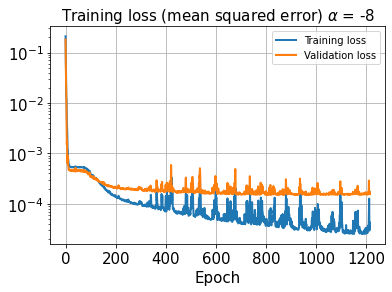

In [37]:
hist = history.history
plt.plot(hist['loss'], lw=2)
plt.plot(hist['val_loss'], lw=2)
plt.title(r'Training loss (mean squared error) $\alpha$ = -8', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
#plt.ylim([5e-5, 1e-1])
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(['Training loss', 'Validation loss'])
plt.grid()
saveName = case_storage + "\\TrainingLoss_val" + str(val_rate) + "test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

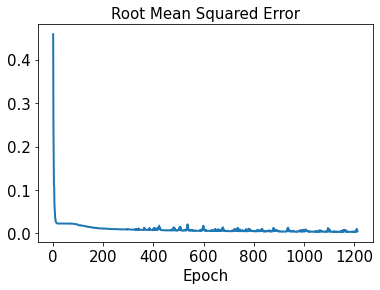

In [38]:
plt.plot(hist['rmse'], lw=2)
plt.title('Root Mean Squared Error', size=15)
plt.xlabel('Epoch', size=15)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.show()

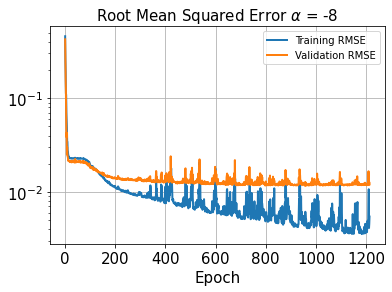

In [39]:
plt.plot(hist['rmse'], lw=2)
plt.plot(hist['val_rmse'], lw=2)
plt.title(r'Root Mean Squared Error $\alpha$ = -8', size=15)
plt.xlabel('Epoch', size=15)
plt.yscale('log')
plt.tick_params(axis='both', which='major', labelsize=15)
plt.legend(['Training RMSE', 'Validation RMSE'])
plt.grid()
saveName = case_storage + "\\RMSE_val" + str(val_rate) + "test"+str(test_rate) + ".jpg"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

In [40]:
test_results = model.evaluate(x_test)

1/1 [==============================] - 0s 129ms/step - loss: 1.2610e-05 - rmse: 0.0000e+00


In [41]:
decoded_train_nor = model.predict(x_train)
decoded_val_nor = model.predict(x_val)
decoded_test_nor = model.predict(x_test)

1/1 [==============================] - 0s 92ms/step


In [42]:
decoded_train = decoded_train_nor*(targetMax-targetMin) + targetMin
decoded_val = decoded_val_nor*(targetMax-targetMin) + targetMin
decoded_test = decoded_test_nor*(targetMax-targetMin) + targetMin

In [43]:
os.chdir("D:\\TrainedModels\\20221101")
model_name = "20221101AeroCNN-II_FlowField_nGrid128_alpha-8_val" + str(val_rate) + "test"+str(test_rate)+".h5"
model.save(model_name, overwrite=True, include_optimizer=True, save_format='h5')

In [44]:
error_train_abs = np.abs(decoded_train - y_train)

In [45]:
error_val_abs = np.abs(decoded_val - y_val)

In [46]:
error_test_abs = np.abs(decoded_test - y_test)

In [47]:
l2_error_train = np.sqrt(np.sum((decoded_train - y_train)**2) / np.sum(y_train**2))
print(l2_error_train)

0.007233336382341438


In [48]:
l2_error_val = np.sqrt(np.sum((decoded_val - y_val)**2) / np.sum(y_val**2))
print(l2_error_val)

0.022959879419540145


In [49]:
l2_error_test = np.sqrt(np.sum((decoded_test - y_test)**2) / np.sum(y_test**2))
print(l2_error_test)

0.03086744964620873


In [50]:
l2_error_train_list = []
for i in range(0, len(aa_train)):
    l2_error_train_data = np.sqrt(np.sum((decoded_train[i] - y_train[i])**2) / np.sum(y_train[i]**2))
    l2_error_train_list.append(l2_error_train_data)

In [51]:
l2_error_val_list = []
for i in range(0, len(aa_val)):
    l2_error_val_data = np.sqrt(np.sum((decoded_val[i] - y_val[i])**2) / np.sum(y_val[i]**2))
    l2_error_val_list.append(l2_error_val_data)

In [52]:
l2_error_test_list = []
for i in range(0, len(aa_test)):
    l2_error_test_data = np.sqrt(np.sum((decoded_test[i] - y_test[i])**2) / np.sum(y_test[i]**2))
    l2_error_test_list.append(l2_error_test_data)

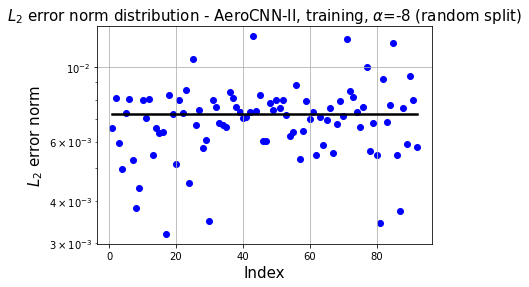

In [53]:
plt.plot(np.linspace(1, aa_train.shape[0], aa_train.shape[0]),
         l2_error_train*np.ones(aa_train.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_train.shape[0], aa_train.shape[0]), l2_error_train_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title(r'$L_2$ error norm distribution - AeroCNN-II, training, $\alpha$=-8 (random split)', fontsize=15)
plt.grid()
saveName = case_storage + "\\trainingErrorDistribution"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

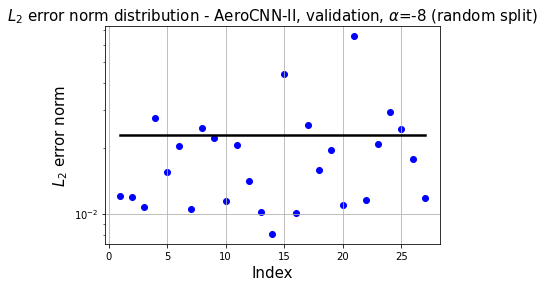

In [54]:
plt.plot(np.linspace(1, aa_val.shape[0], aa_val.shape[0]),
         l2_error_val*np.ones(aa_val.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_val.shape[0], aa_val.shape[0]), l2_error_val_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title(r'$L_2$ error norm distribution - AeroCNN-II, validation, $\alpha$=-8 (random split)', fontsize=15)
plt.grid()
saveName = case_storage + "\\validationErrorDistribution"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

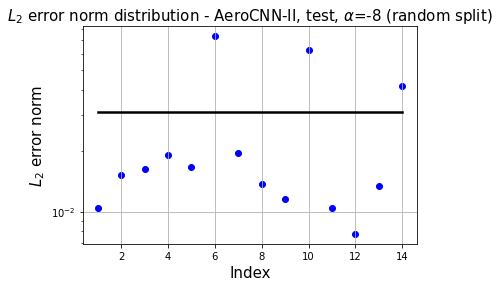

In [55]:
plt.plot(np.linspace(1, aa_test.shape[0], aa_test.shape[0]),
         l2_error_test*np.ones(aa_test.shape[0],), 'k', lw=2.5)
plt.scatter(np.linspace(1, aa_test.shape[0], aa_test.shape[0]), l2_error_test_list, c='b')
plt.xlabel('Index', fontsize=15)
plt.ylabel('$L_2$ error norm', fontsize=15)
plt.yscale('log')
plt.title(r'$L_2$ error norm distribution - AeroCNN-II, test, $\alpha$=-8 (random split)', fontsize=15)
plt.grid()
saveName = case_storage + "\\testErrorDistribution"
plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
plt.show()

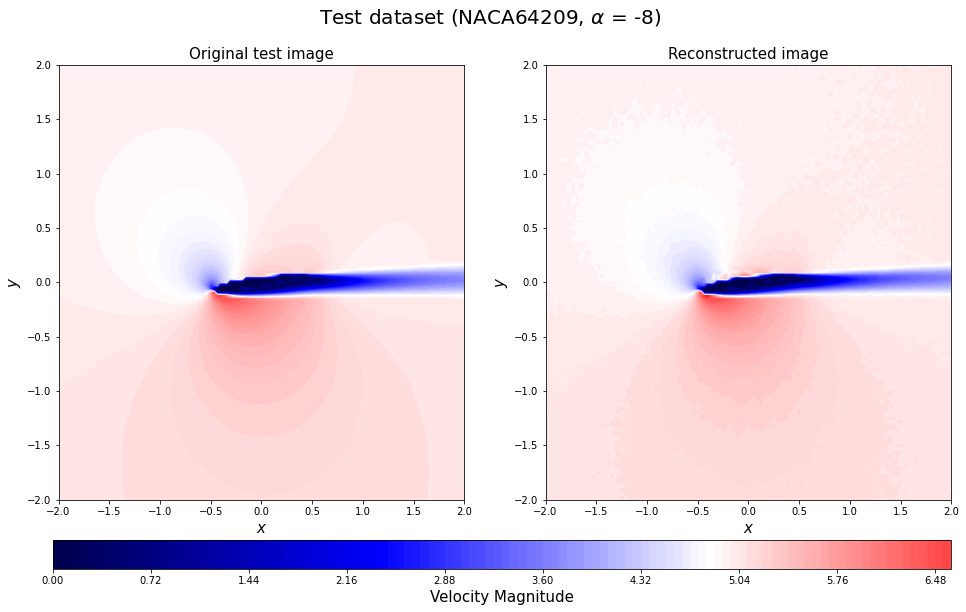

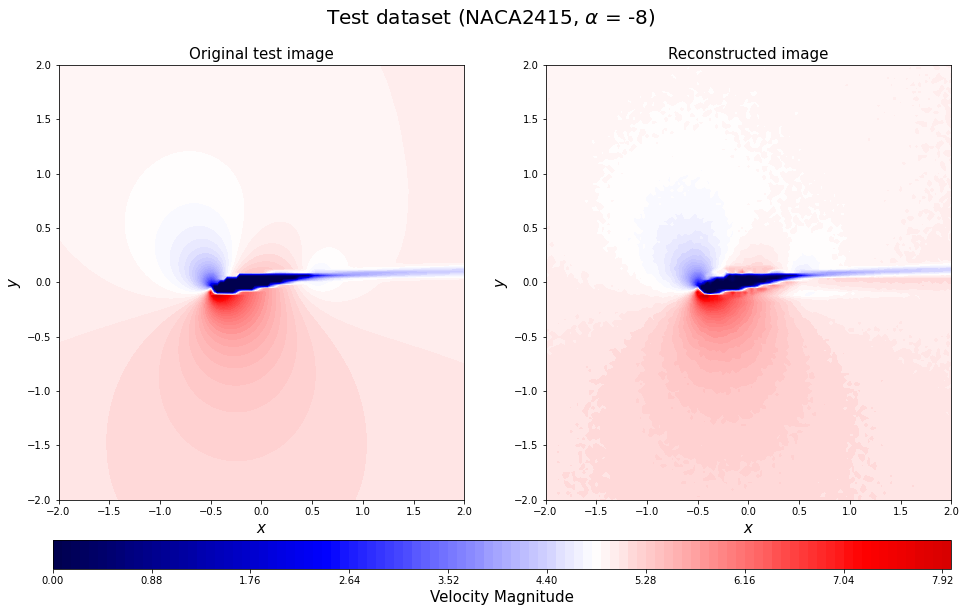

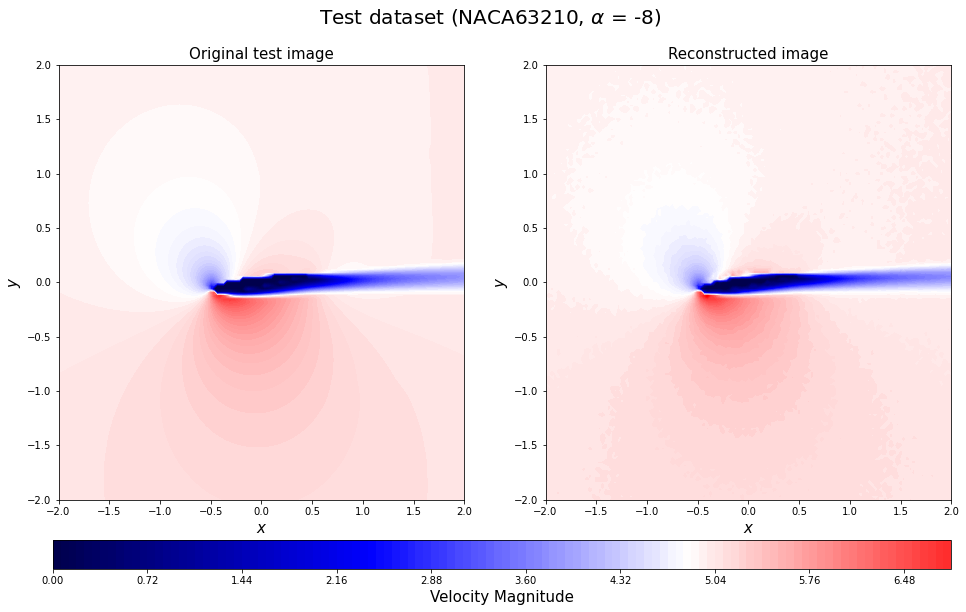

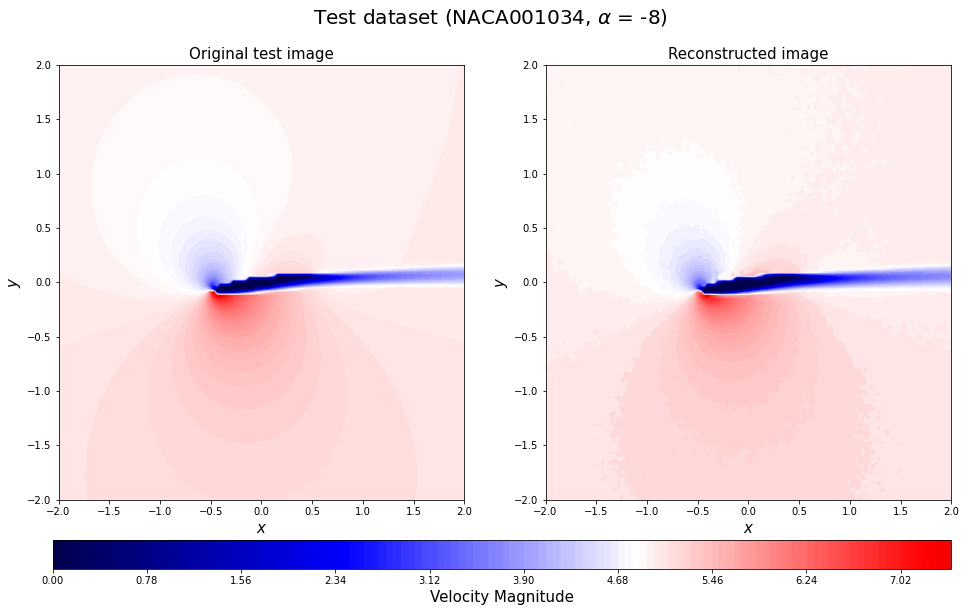

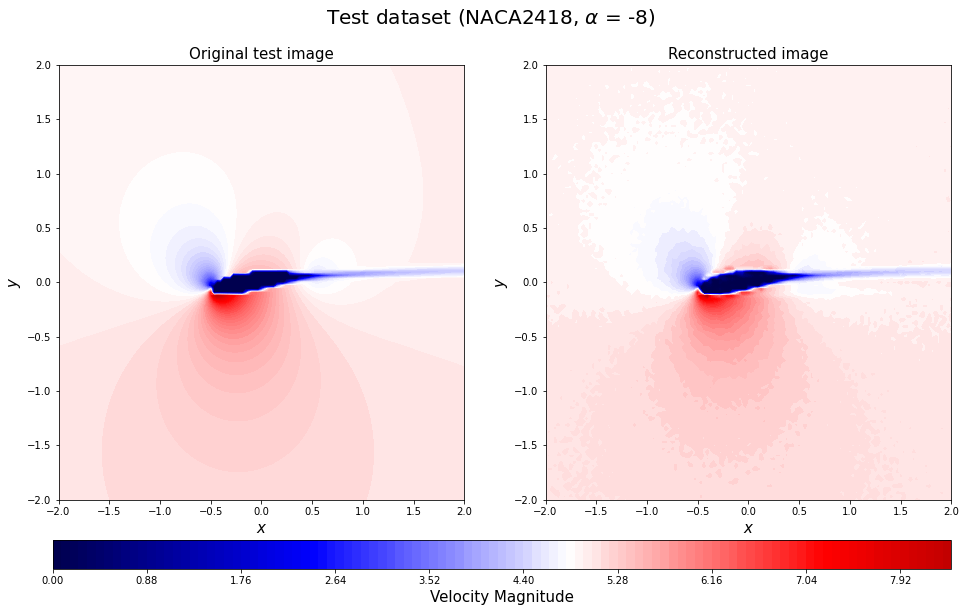

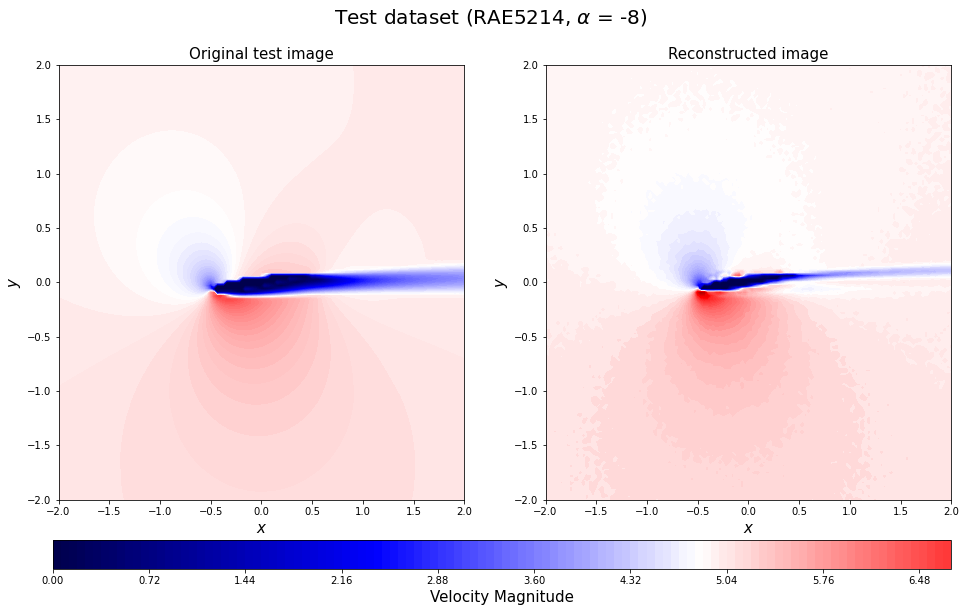

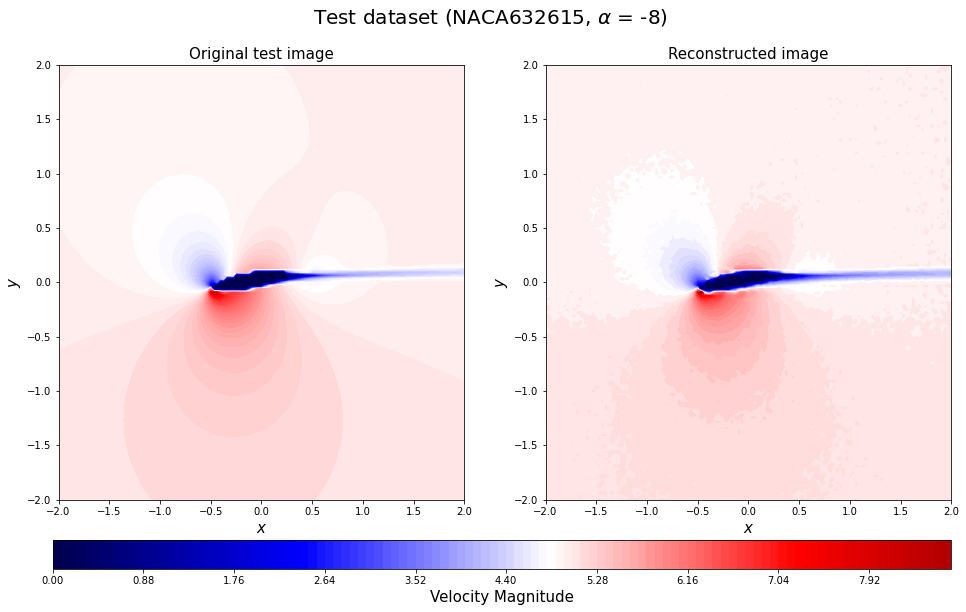

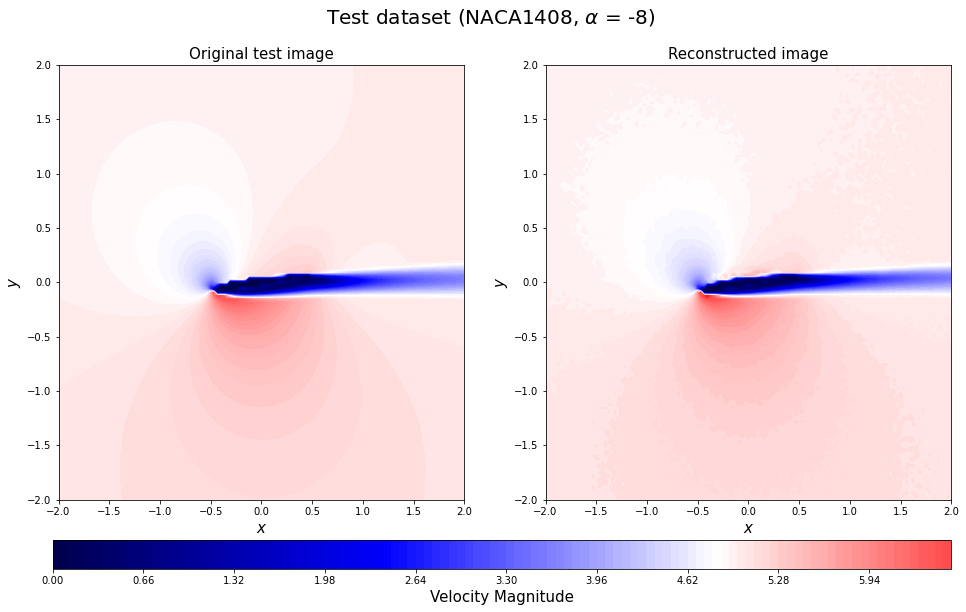

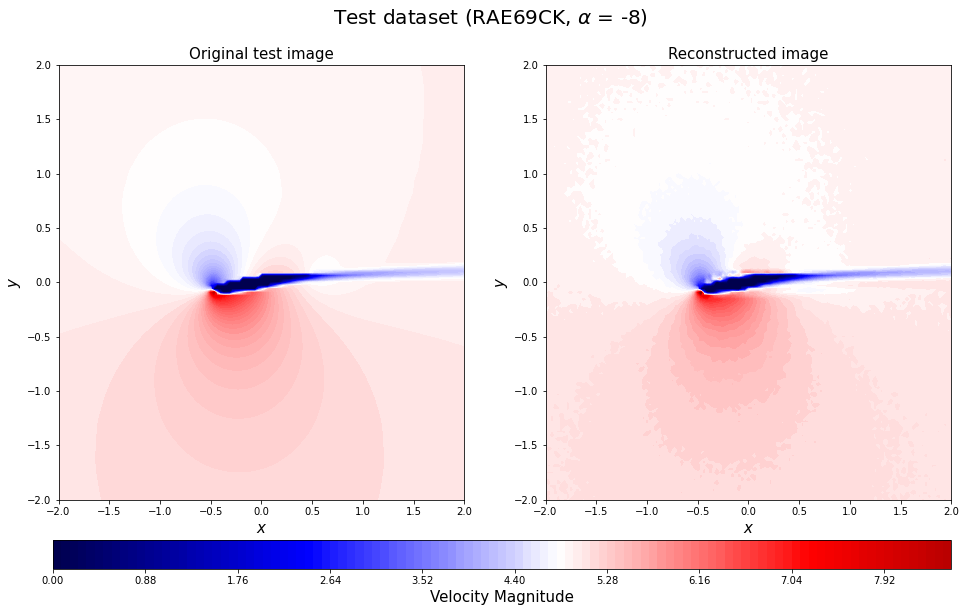

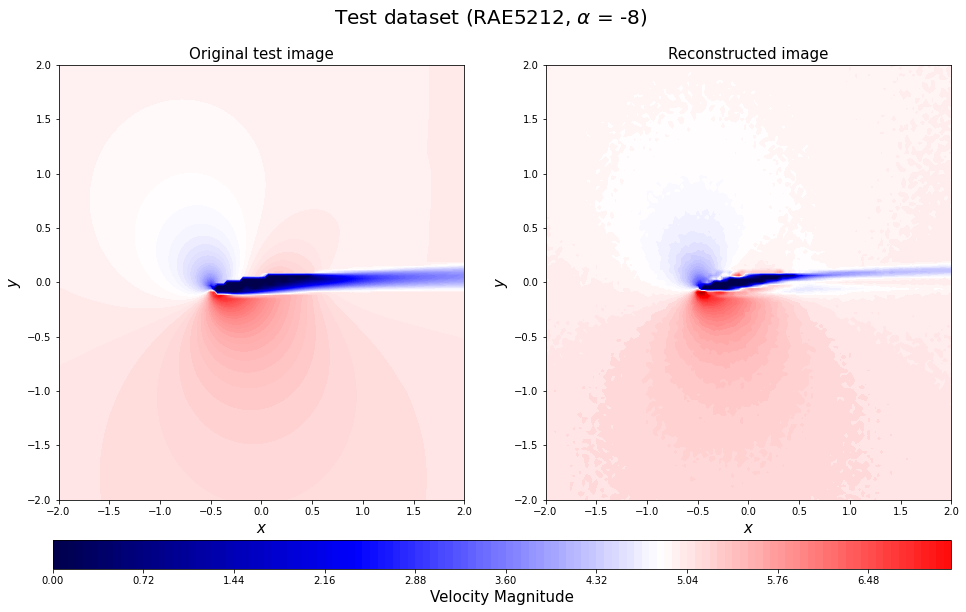

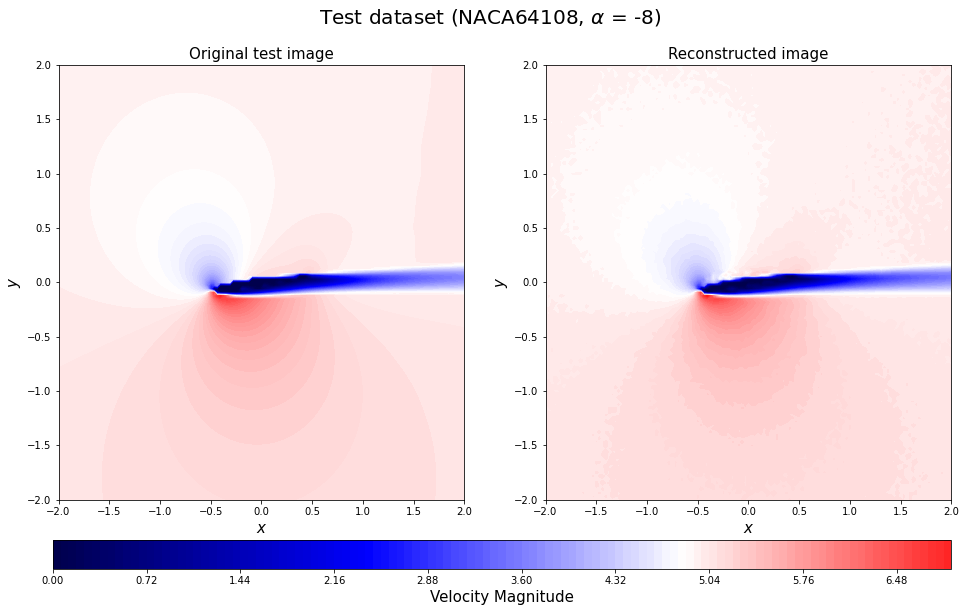

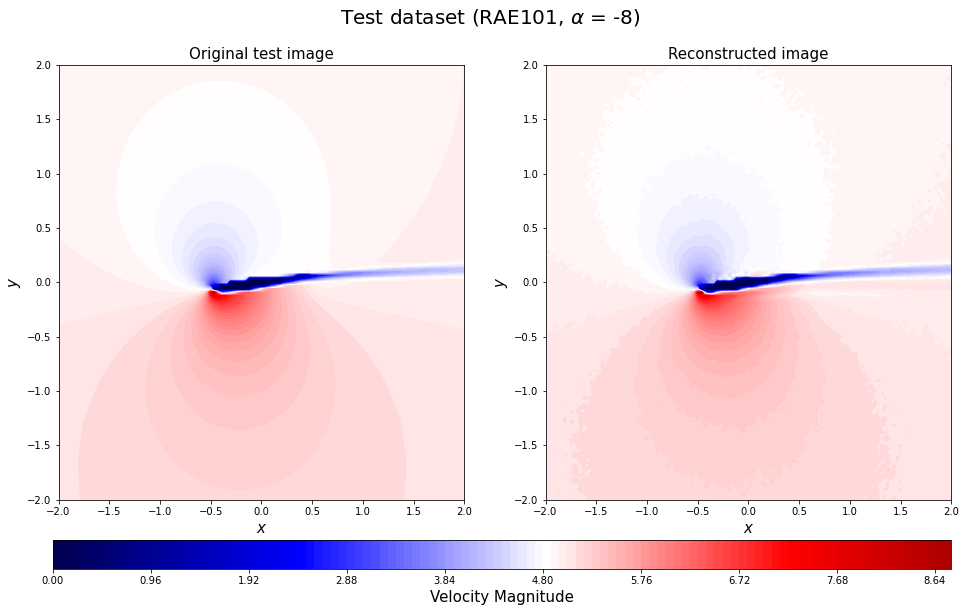

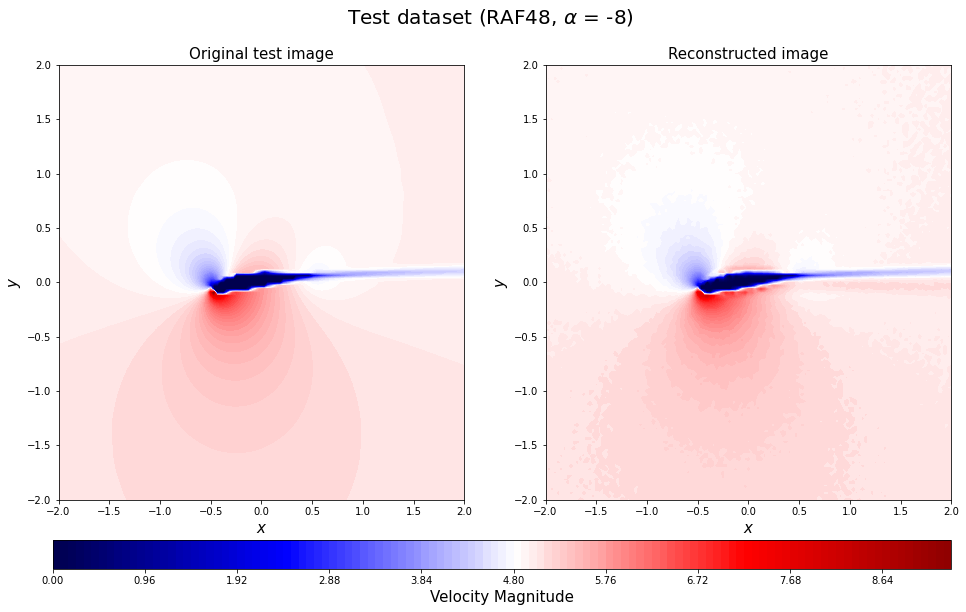

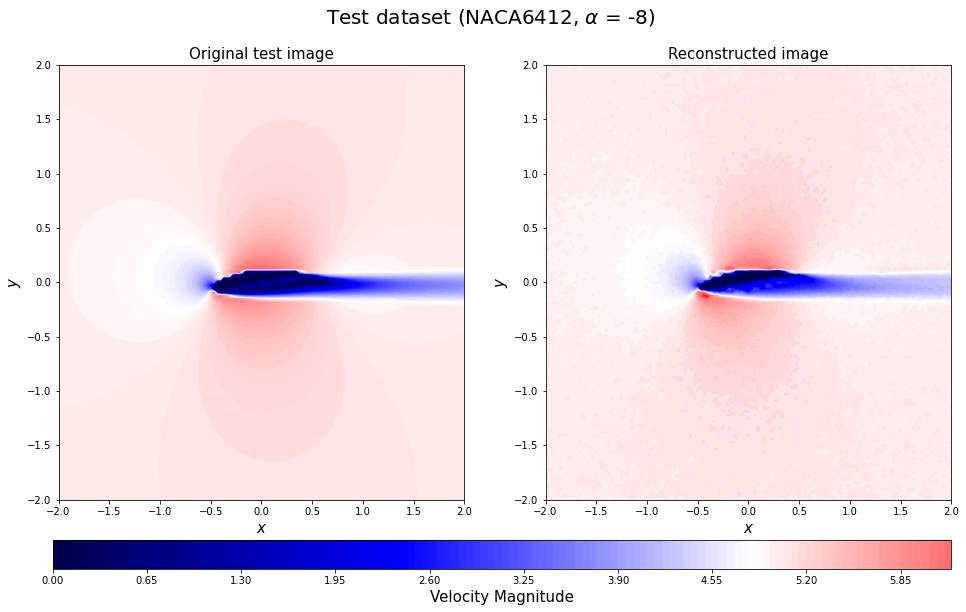

In [56]:
n_grid =129
for c in range(0,14):
    plt.figure(figsize=(16, 8))
    y_test2_rotate = y_test[c].reshape(n_grid,n_grid)
    decoded_rotate = decoded_test[c].reshape(n_grid,n_grid)

    xrange = np.linspace(-2, 2, n_grid)
    yrange = np.linspace(-2, 2, n_grid)
    xmesh, ymesh = np.meshgrid(xrange, yrange)

    ax = plt.subplot(1, 2, 1)
    a1 = plt.contourf(xmesh, ymesh, y_test2_rotate, vmin=targetMin, vmax=targetMax, levels=128, cmap='seismic')
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_title('Original test image', fontsize=15)

    # Display reconstruction
    ax = plt.subplot(1, 2, 2)
    a2 = plt.contourf(xmesh, ymesh, decoded_rotate, vmin=targetMin, vmax=targetMax, levels=128, cmap='seismic')
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_title('Reconstructed image', fontsize=15)
    cax = plt.axes([0.12, 0.005, 0.78, 0.05])
    cbar = plt.colorbar(a1, cax=cax, orientation="horizontal")
    cbar.set_label('Velocity Magnitude', fontsize=15)
    #cbar.set_ticks([-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

    plt.suptitle(r'Test dataset (%s, $\alpha$ = %d)' %(np.array2string(geo_test[c])[3:-2], aa_test[c]),fontsize=20)
    saveName = case_storage + "\\testprediction"+str(np.array2string(geo_test[c])[3:-2])+"_alpha"+str(aa_test[c])+".jpg"
    plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

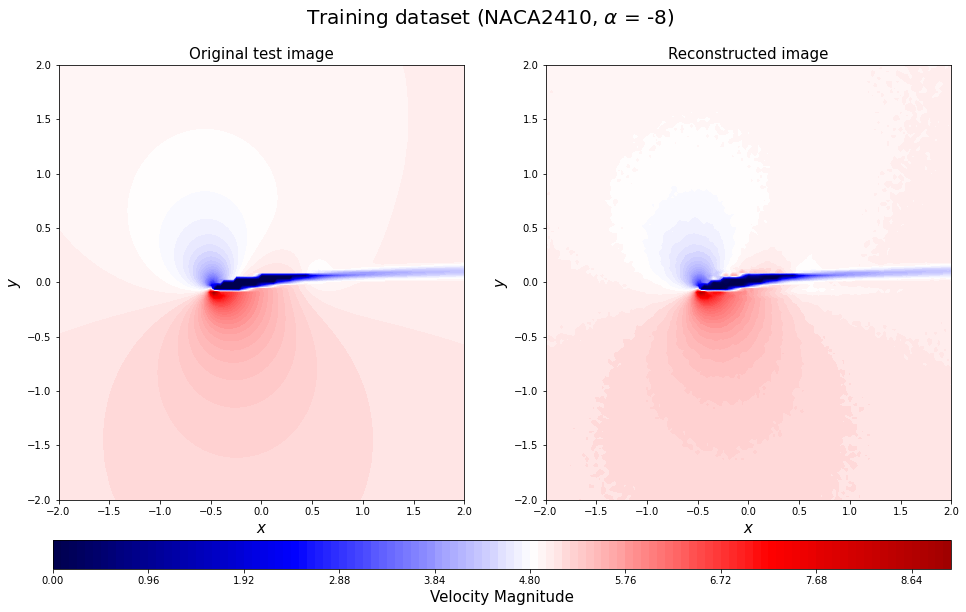

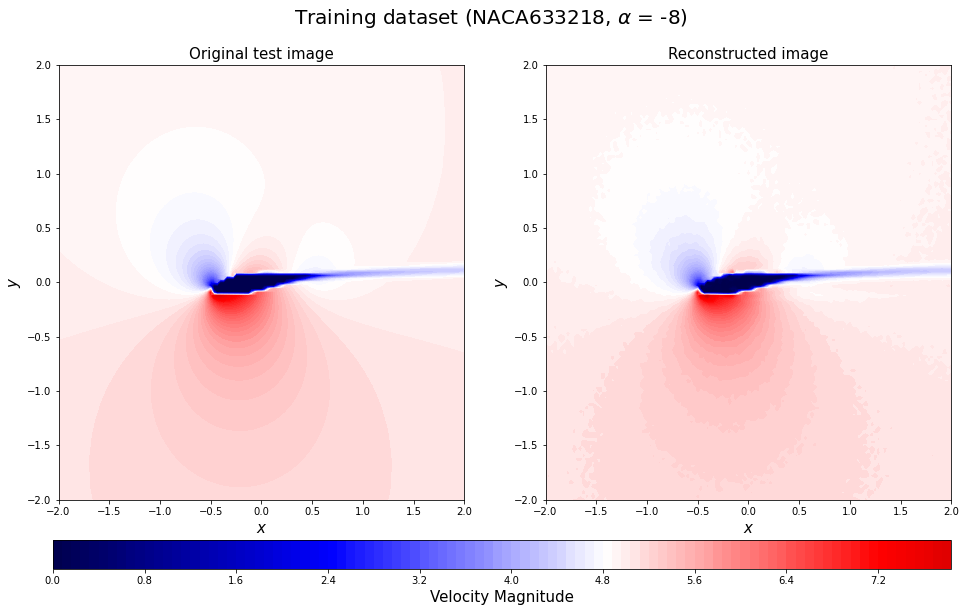

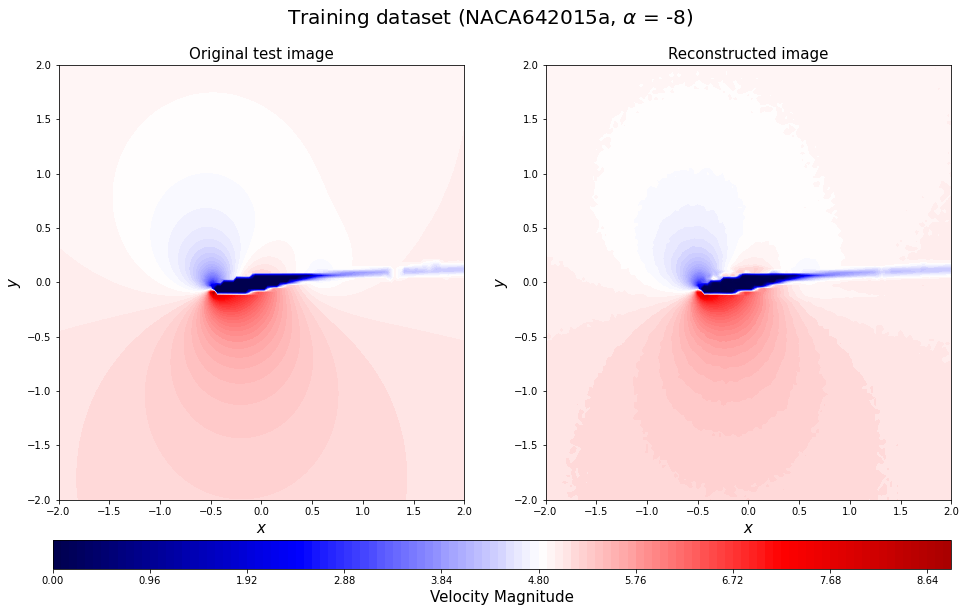

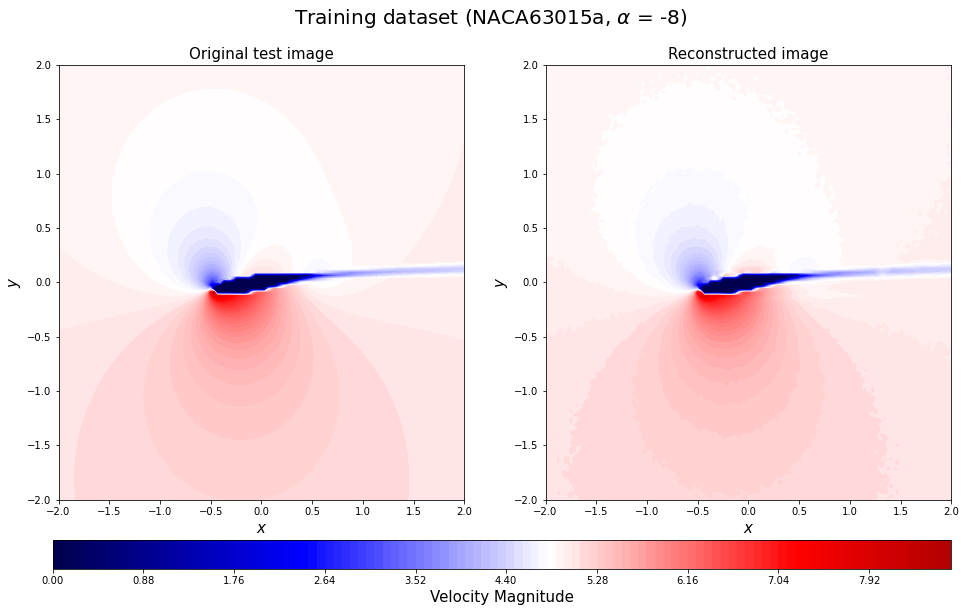

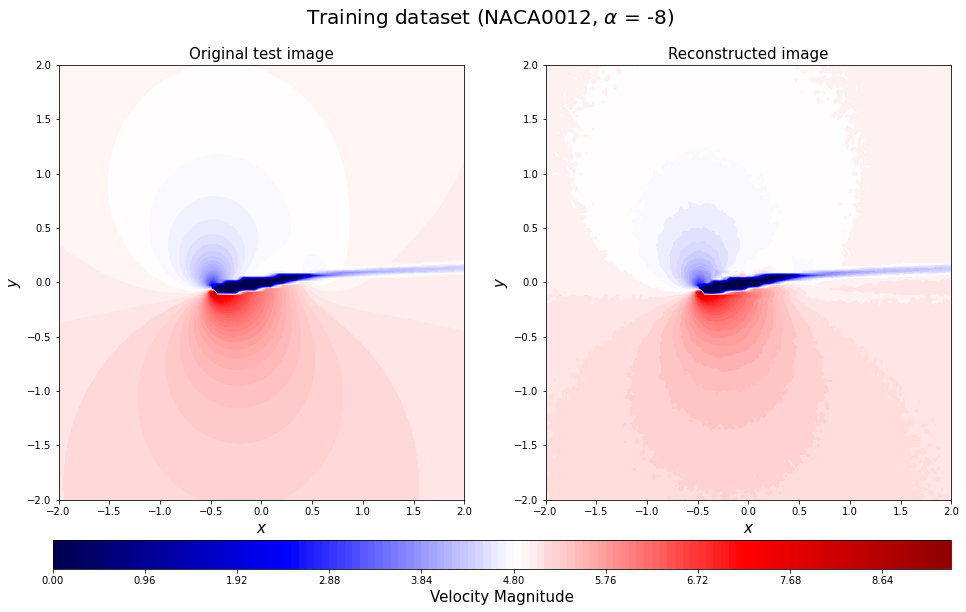

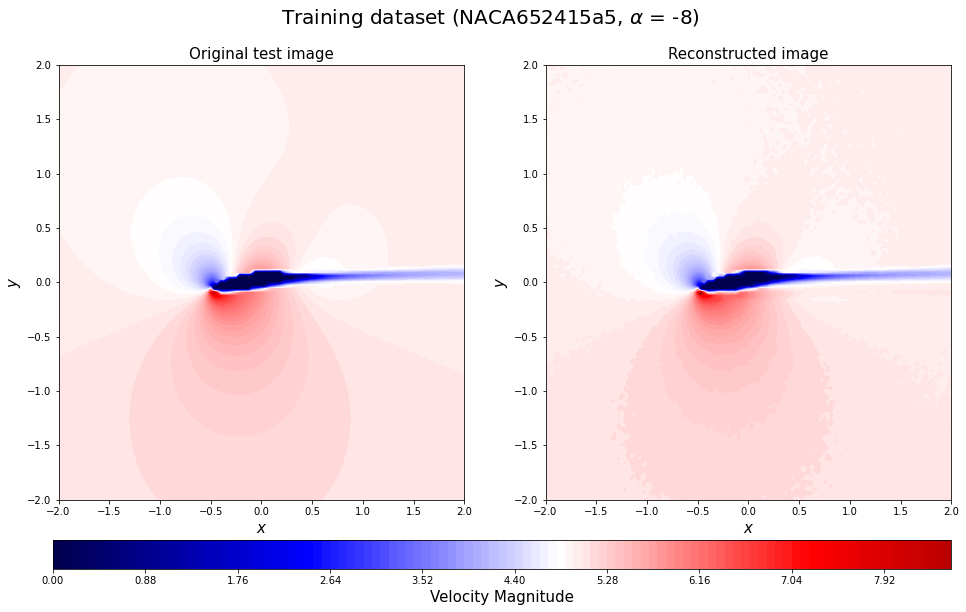

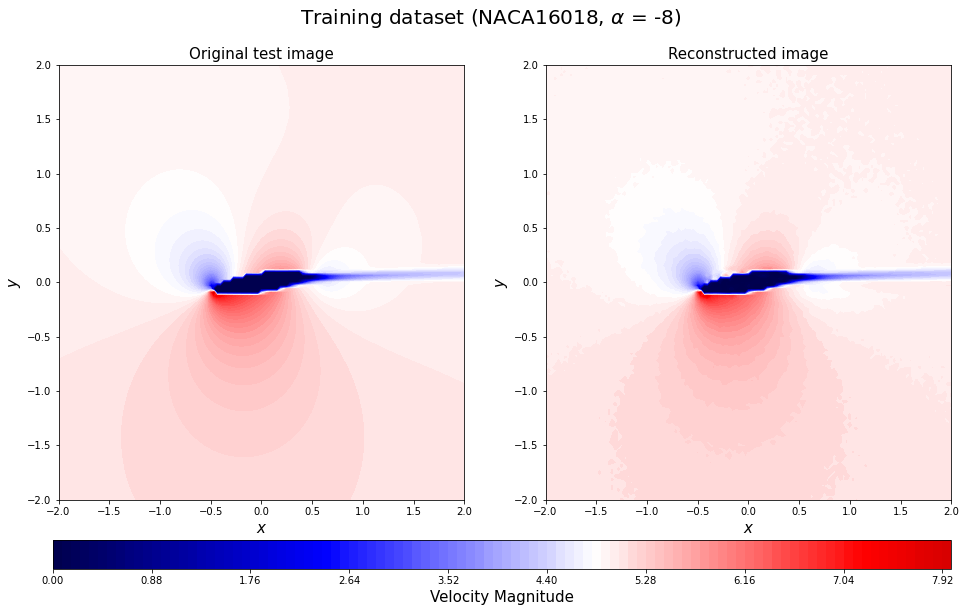

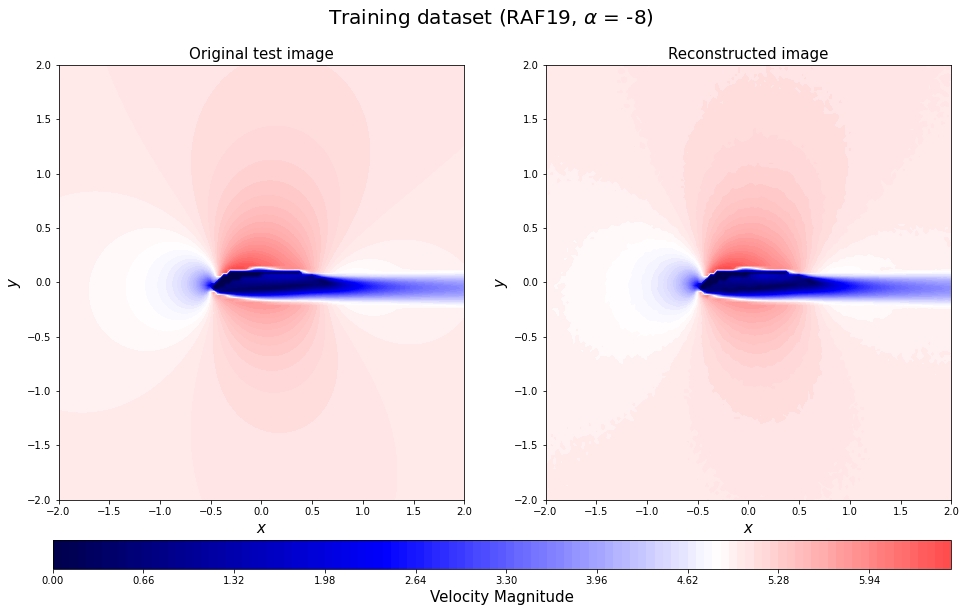

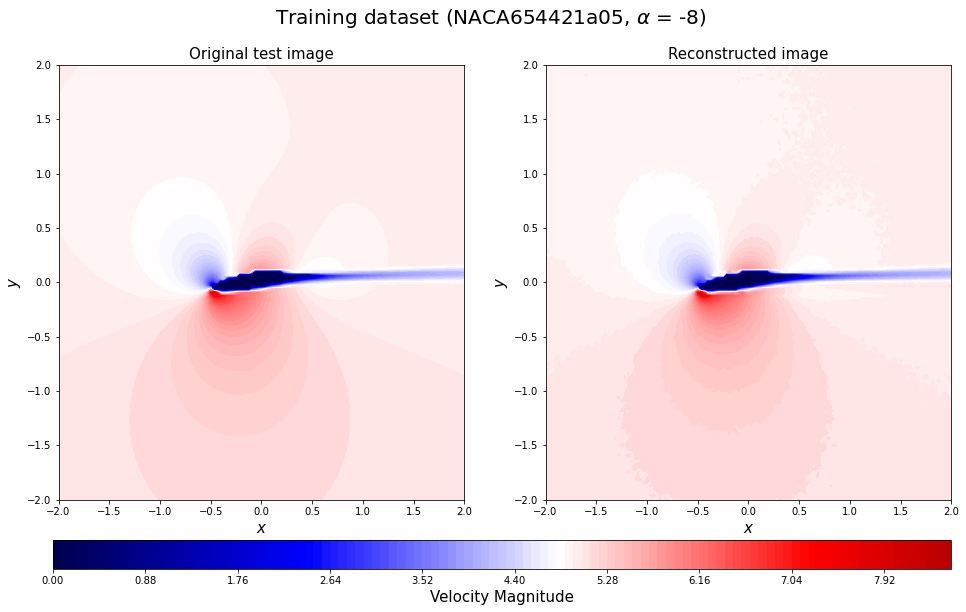

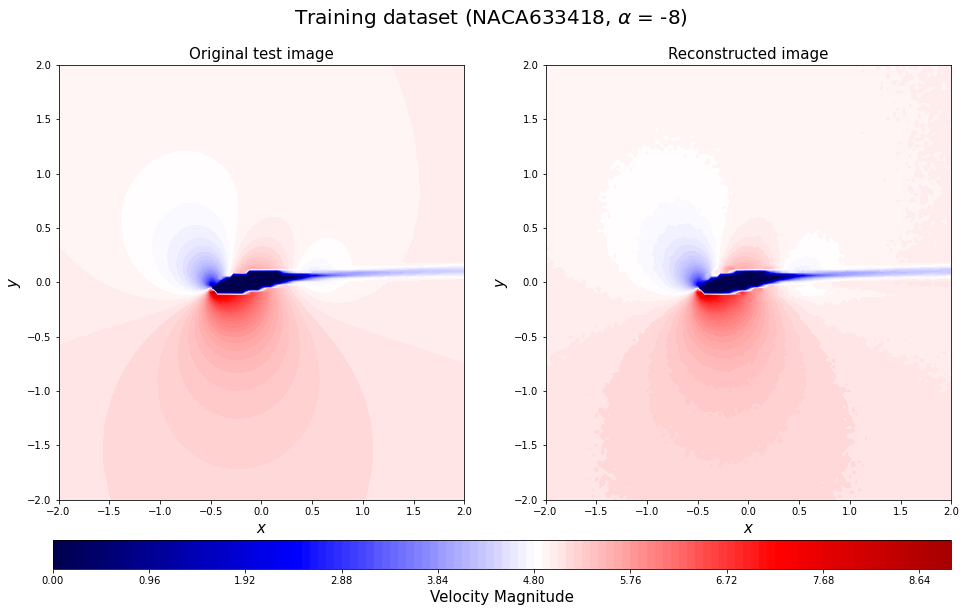

In [57]:
for c in range(0,10):
    plt.figure(figsize=(16, 8))
    y_train0_rotate = y_train[c].reshape(n_grid,n_grid)
    decoded_rotate = decoded_train[c].reshape(n_grid,n_grid)

    xrange = np.linspace(-2, 2, n_grid)
    yrange = np.linspace(-2, 2, n_grid)
    xmesh, ymesh = np.meshgrid(xrange, yrange)

    ax = plt.subplot(1, 2, 1)
    a1 = plt.contourf(xmesh, ymesh, y_train0_rotate, vmin=targetMin, vmax=targetMax, levels=128, cmap='seismic')
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_title('Original test image', fontsize=15)

    # Display reconstruction
    ax = plt.subplot(1, 2, 2)
    a2 = plt.contourf(xmesh, ymesh, decoded_rotate, vmin=targetMin, vmax=targetMax, levels=128, cmap='seismic')
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_title('Reconstructed image', fontsize=15)
    cax = plt.axes([0.12, 0.005, 0.78, 0.05])
    cbar = plt.colorbar(a1, cax=cax, orientation="horizontal")
    cbar.set_label('Velocity Magnitude', fontsize=15)
    #cbar.set_ticks([-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

    plt.suptitle(r'Training dataset (%s, $\alpha$ = %d)' %(np.array2string(geo_train[c])[3:-2], aa_train[c]),fontsize=20)
    saveName = case_storage + "\\trainingprediction"+str(np.array2string(geo_train[c])[3:-2])+"_alpha"+str(aa_train[c])+".jpg"
    plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

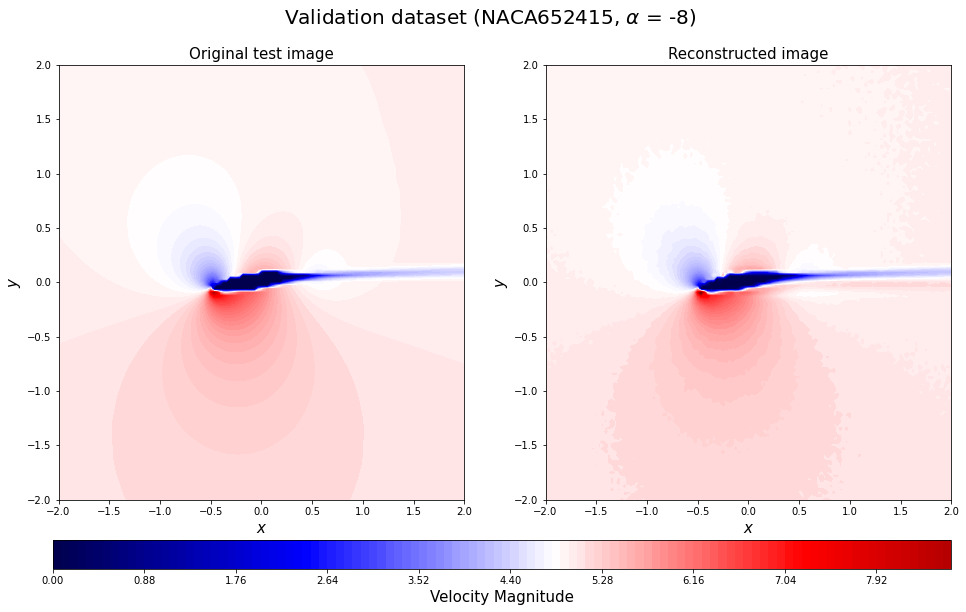

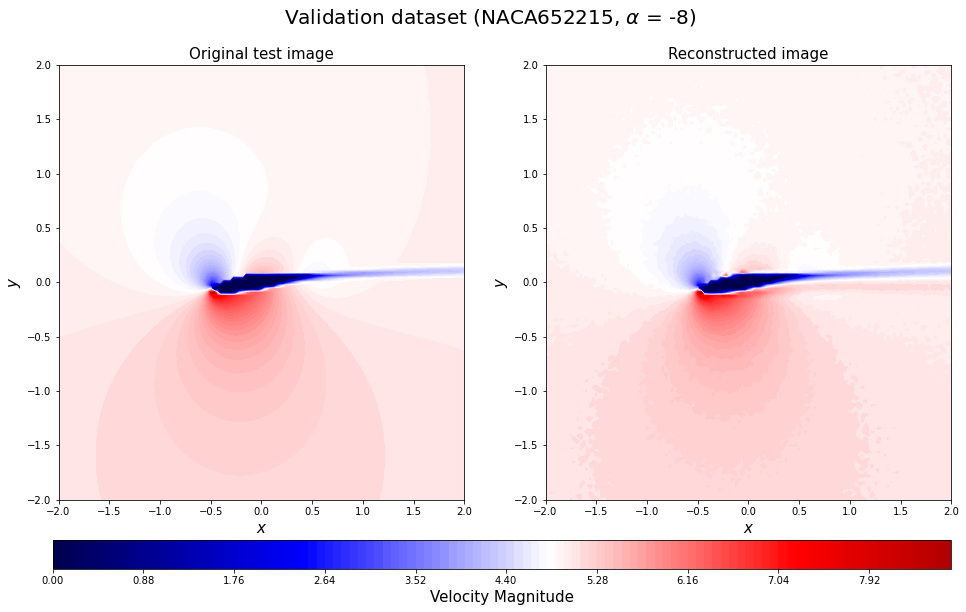

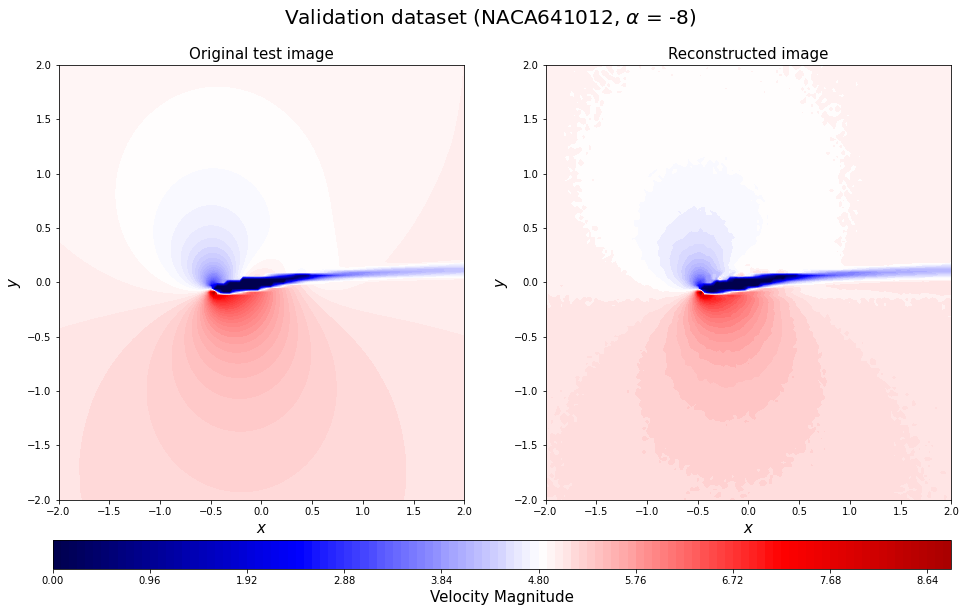

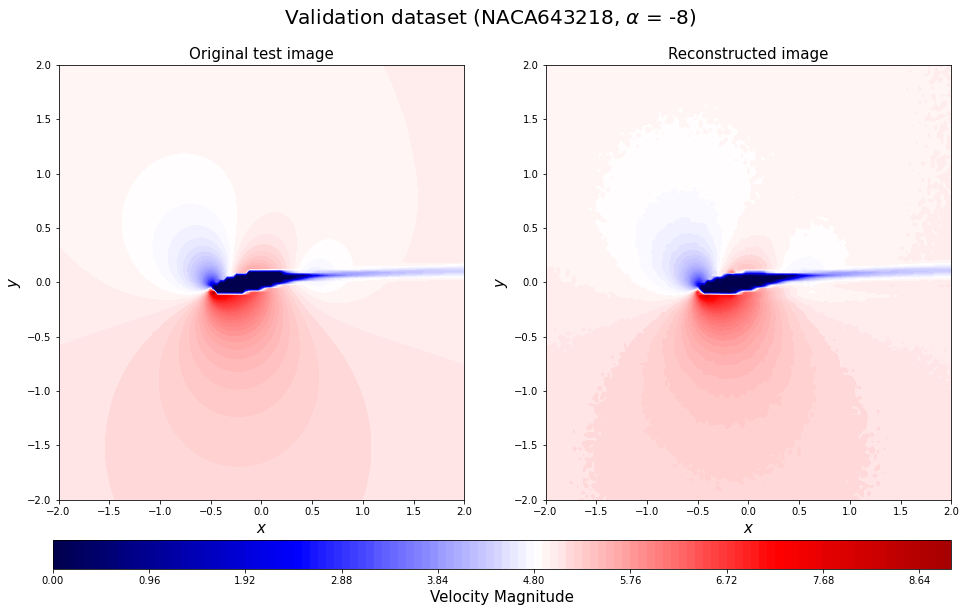

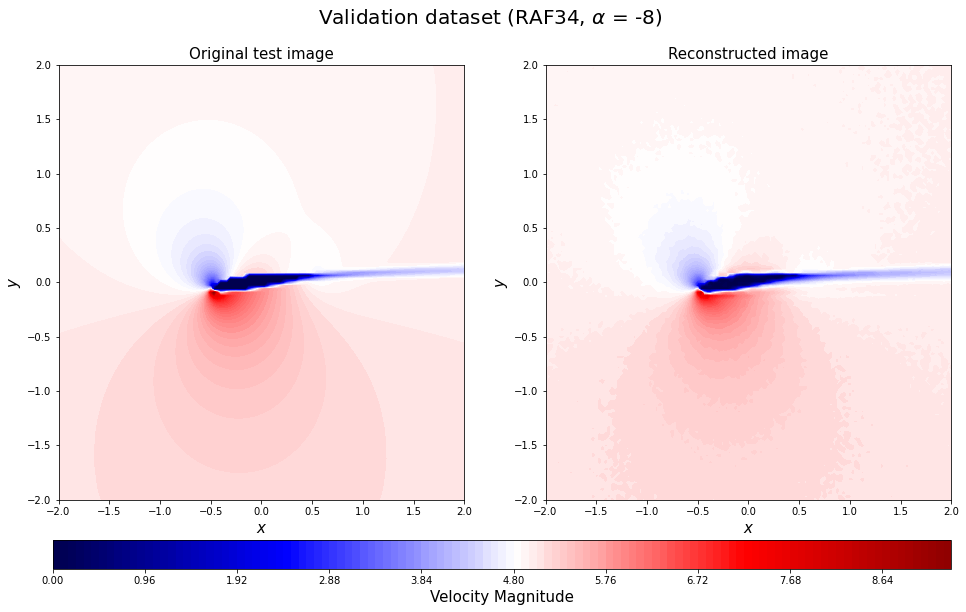

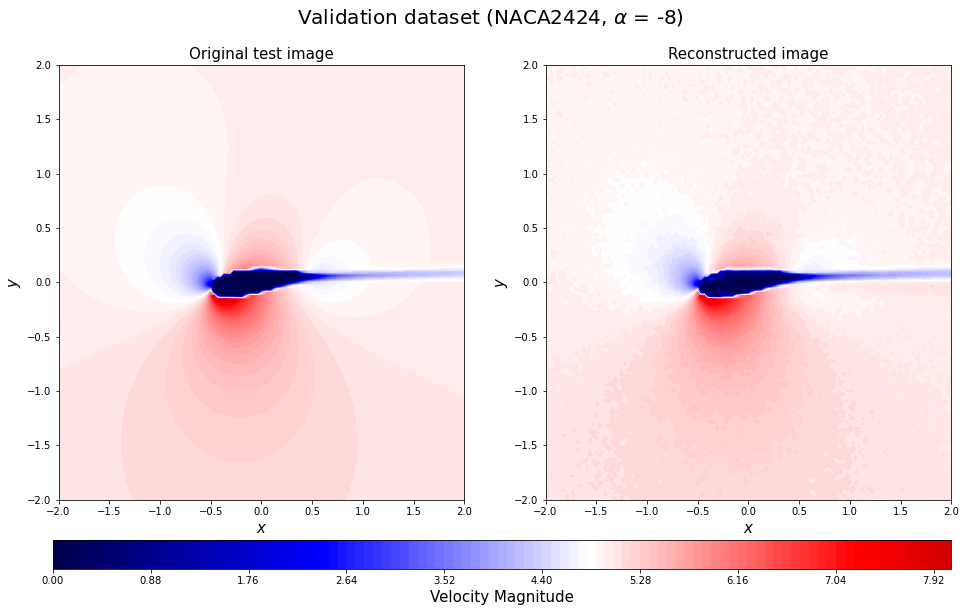

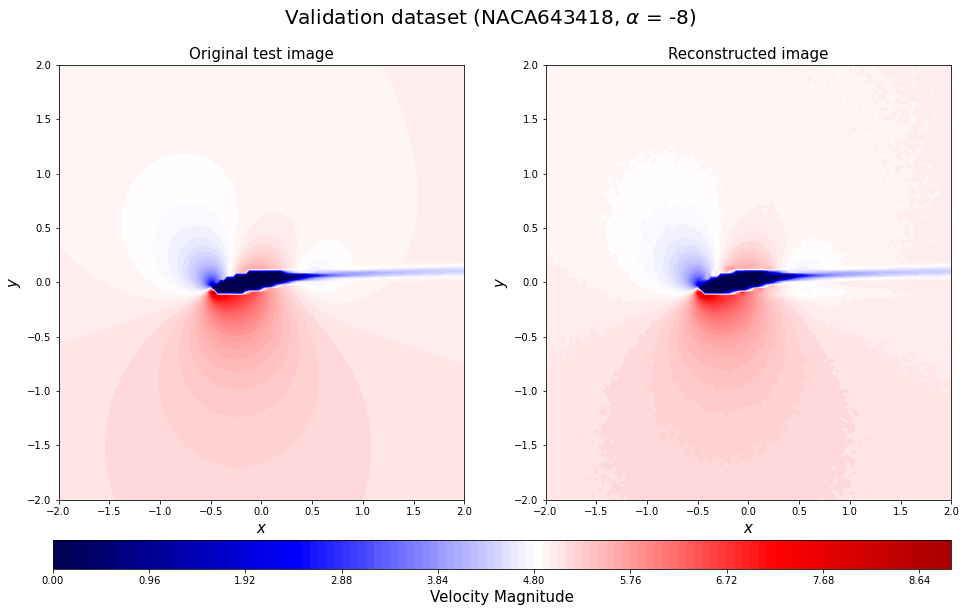

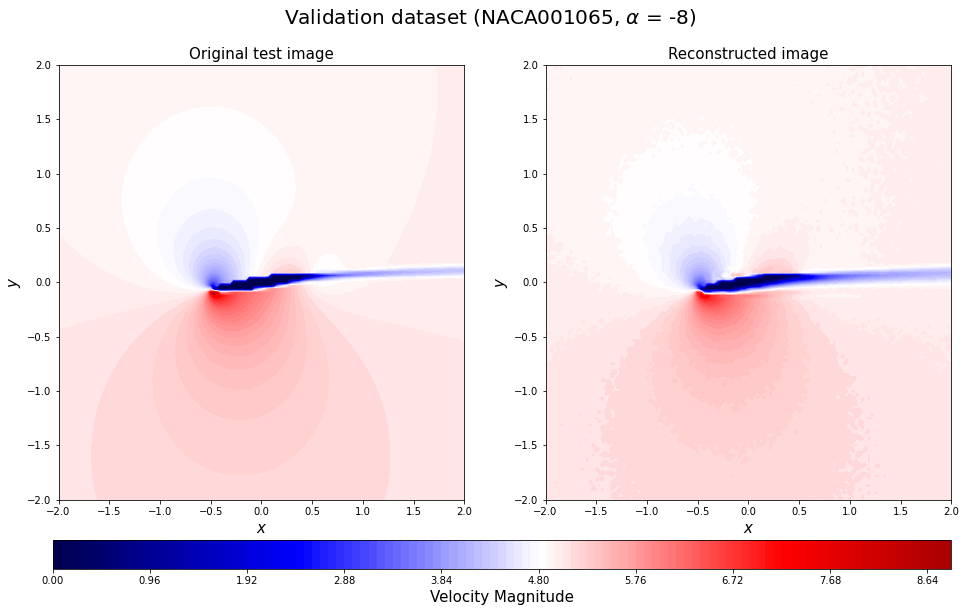

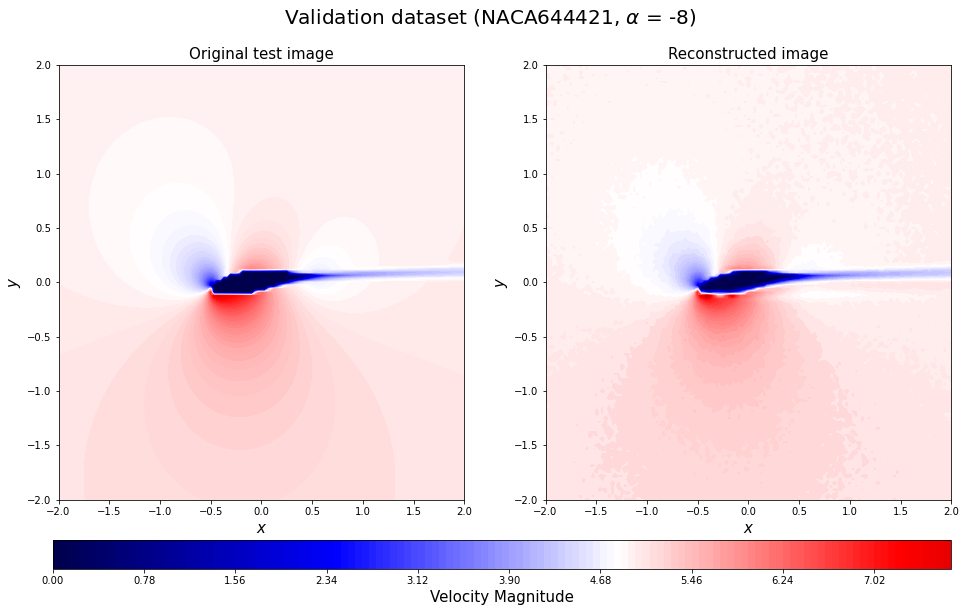

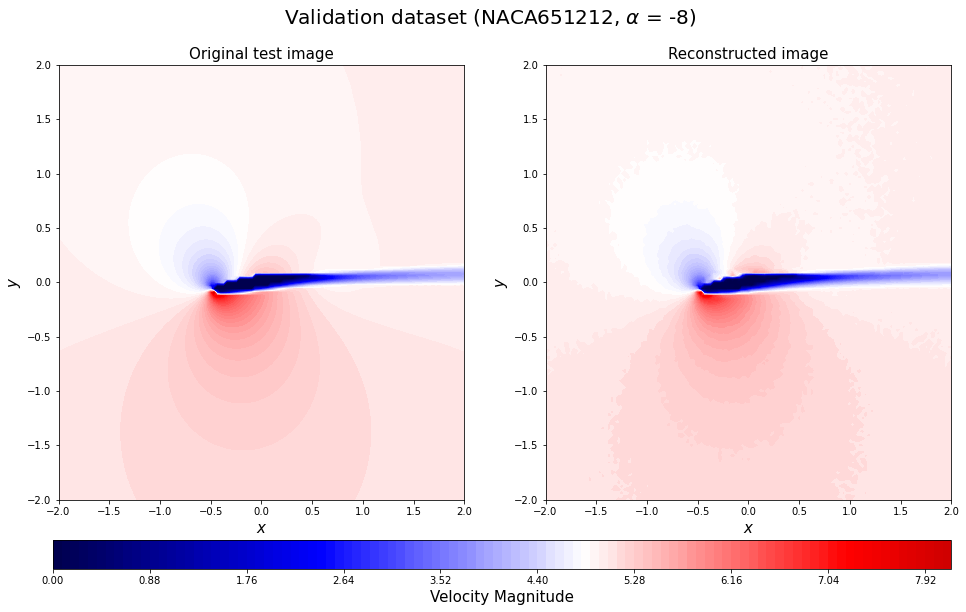

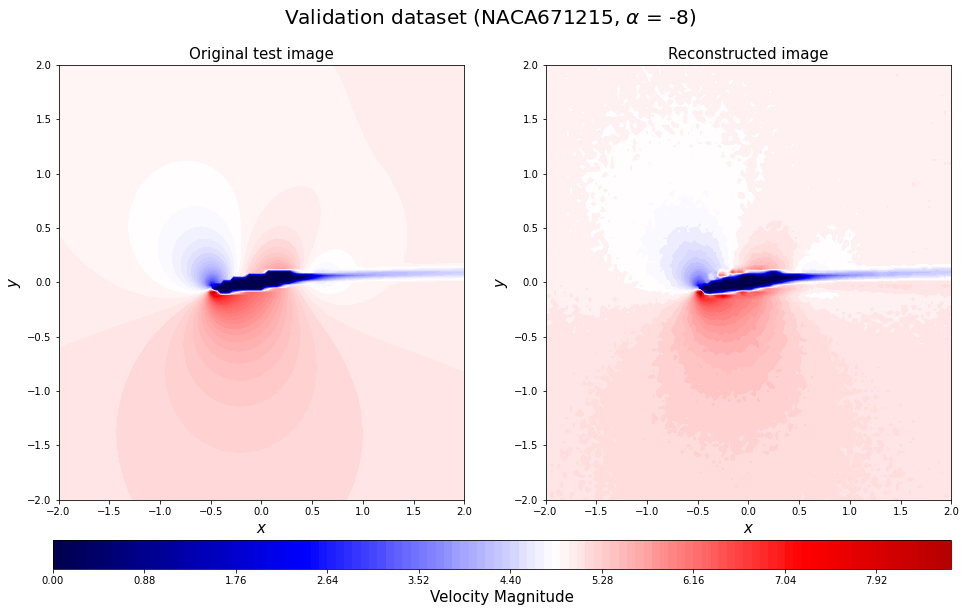

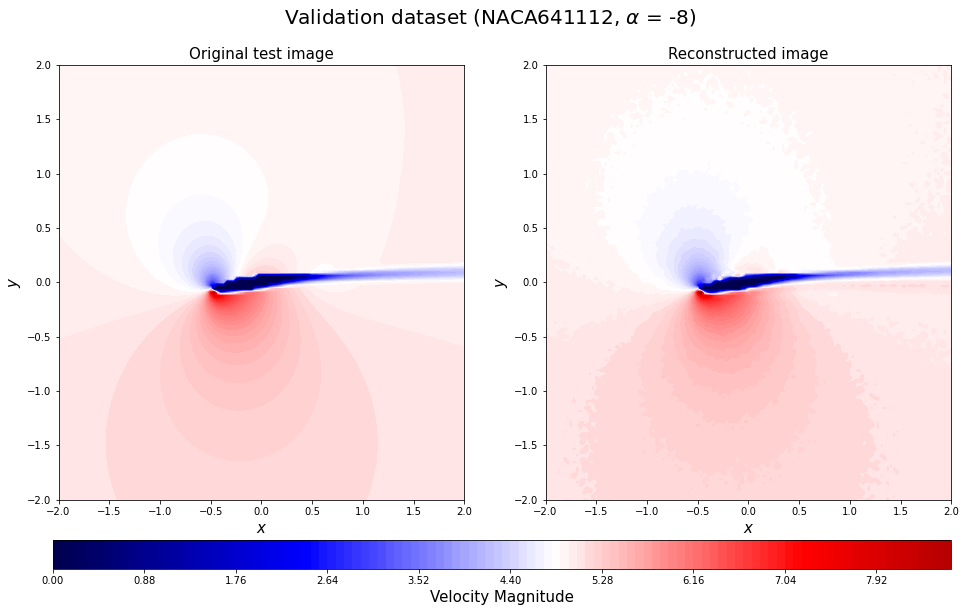

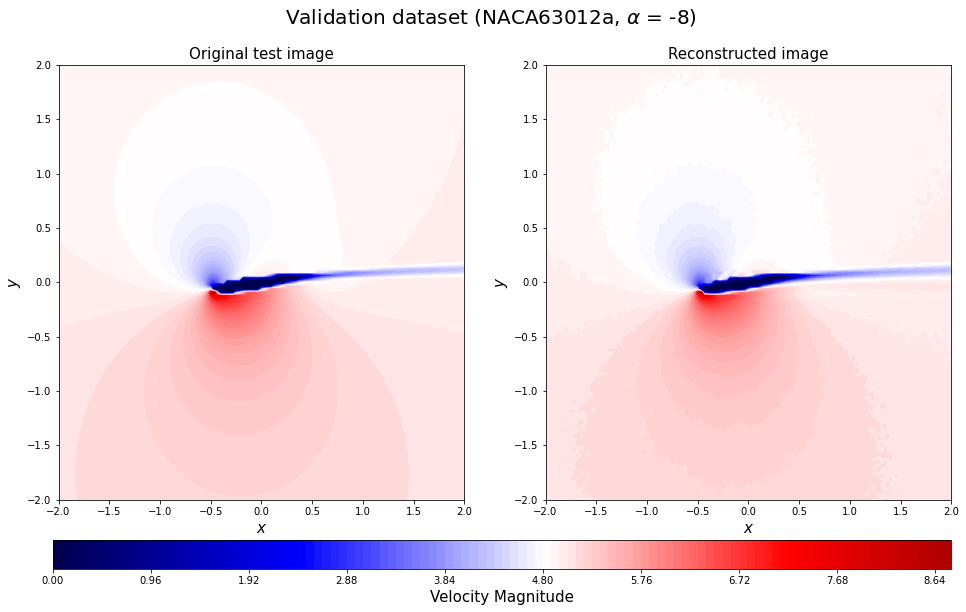

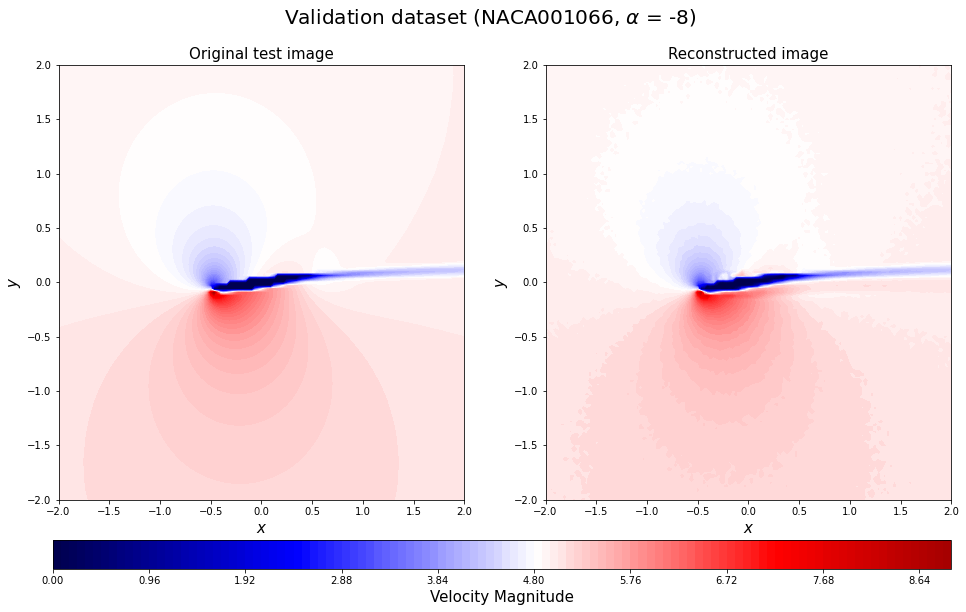

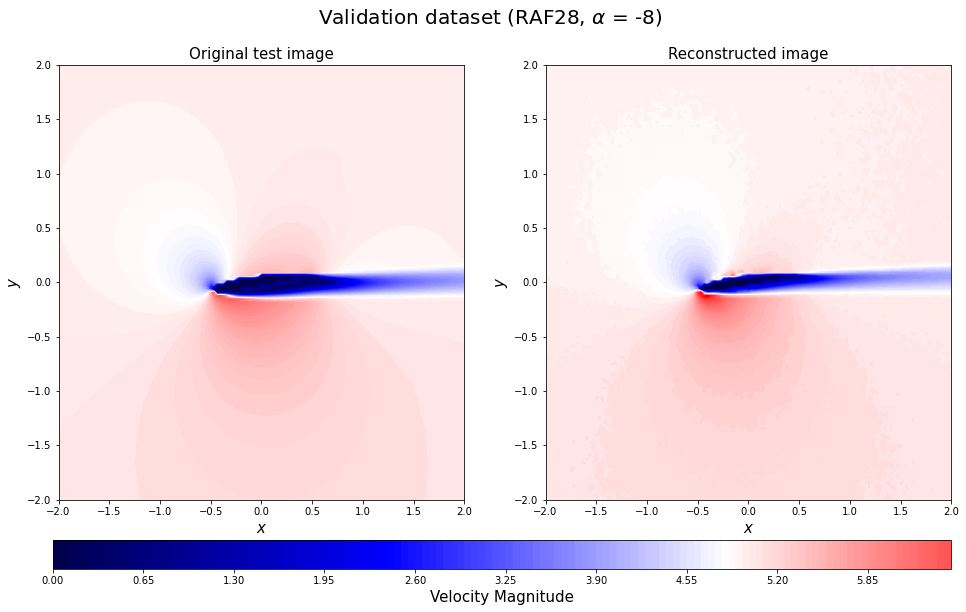

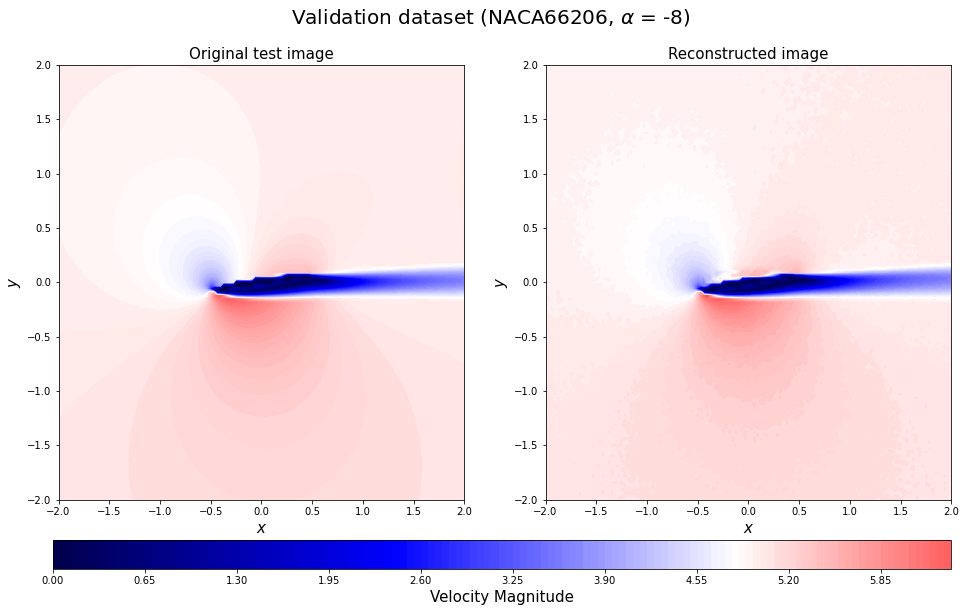

In [58]:
for c in range(0,16):
    plt.figure(figsize=(16, 8))
    y_val20_rotate = y_val[c].reshape(n_grid,n_grid)
    decoded_rotate = decoded_val[c].reshape(n_grid,n_grid)

    xrange = np.linspace(-2, 2, n_grid)
    yrange = np.linspace(-2, 2, n_grid)
    xmesh, ymesh = np.meshgrid(xrange, yrange)

    ax = plt.subplot(1, 2, 1)
    a1 = plt.contourf(xmesh, ymesh, y_val20_rotate, vmin=targetMin, vmax=targetMax, levels=128, cmap='seismic')
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_title('Original test image', fontsize=15)

    # Display reconstruction
    ax = plt.subplot(1, 2, 2)
    a2 = plt.contourf(xmesh, ymesh, decoded_rotate, vmin=targetMin, vmax=targetMax, levels=128, cmap='seismic')
    ax.set_xlabel('$x$', fontsize=15)
    ax.set_ylabel('$y$', fontsize=15)
    ax.set_title('Reconstructed image', fontsize=15)
    cax = plt.axes([0.12, 0.005, 0.78, 0.05])
    cbar = plt.colorbar(a1, cax=cax, orientation="horizontal")
    cbar.set_label('Velocity Magnitude', fontsize=15)
    #cbar.set_ticks([-0.5, -0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])

    plt.suptitle(r'Validation dataset (%s, $\alpha$ = %d)' %(np.array2string(geo_val[c])[3:-2], aa_val[c]),fontsize=20)
    saveName = case_storage + "\\validationprediction"+str(np.array2string(geo_val[c])[3:-2])+"_alpha"+str(aa_val[c])+".jpg"
    plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

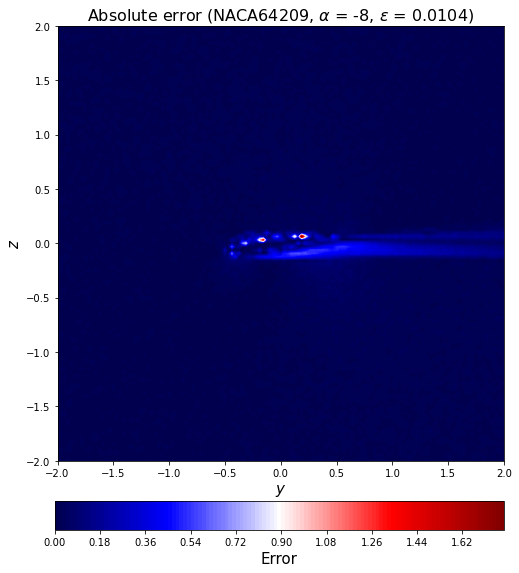

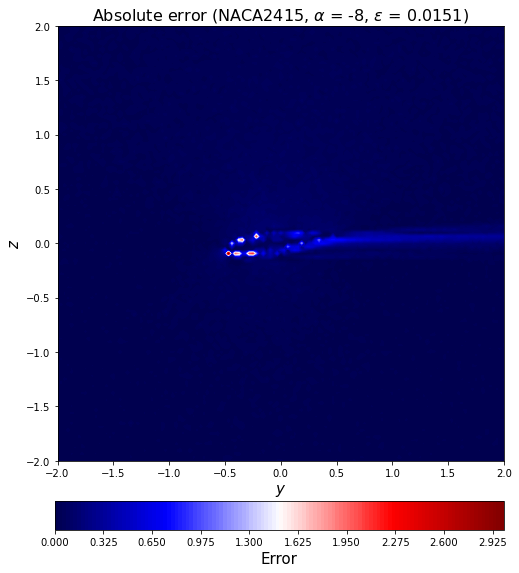

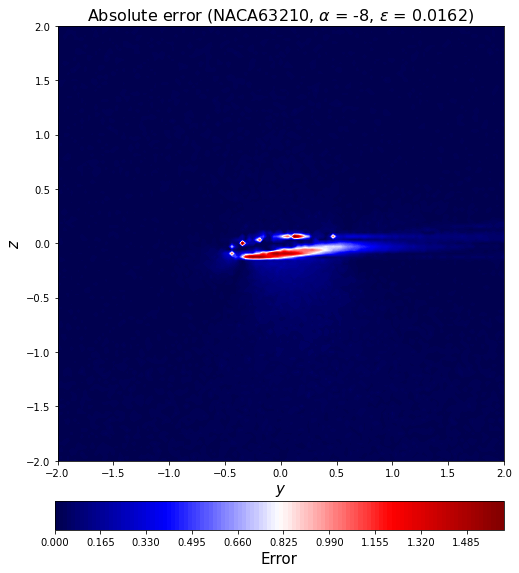

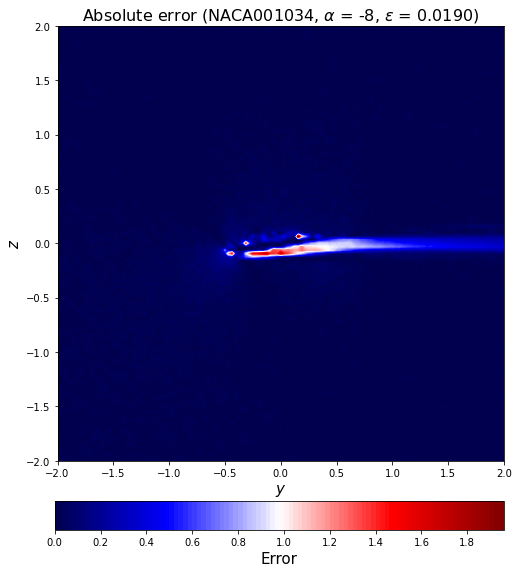

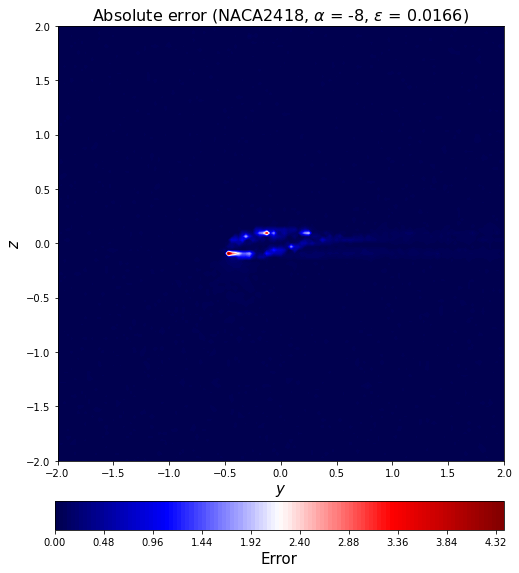

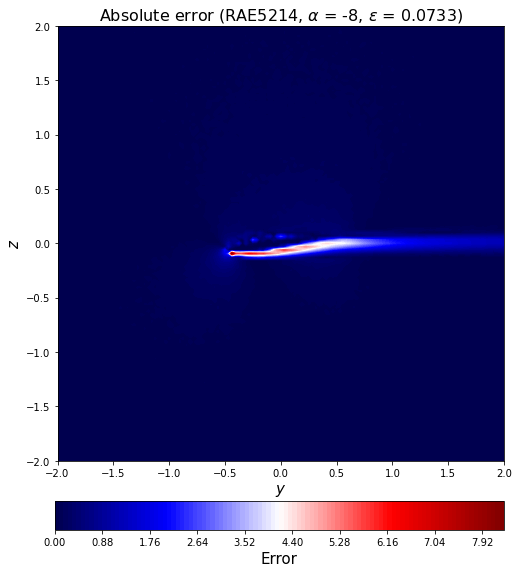

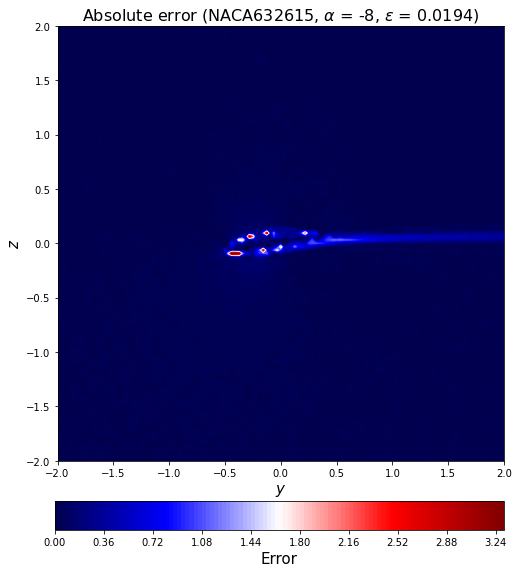

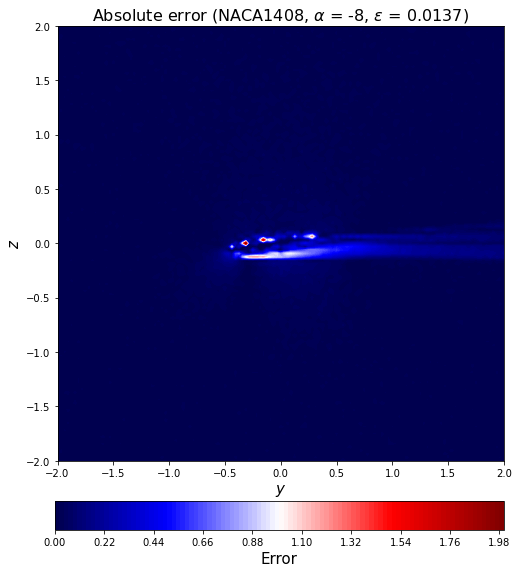

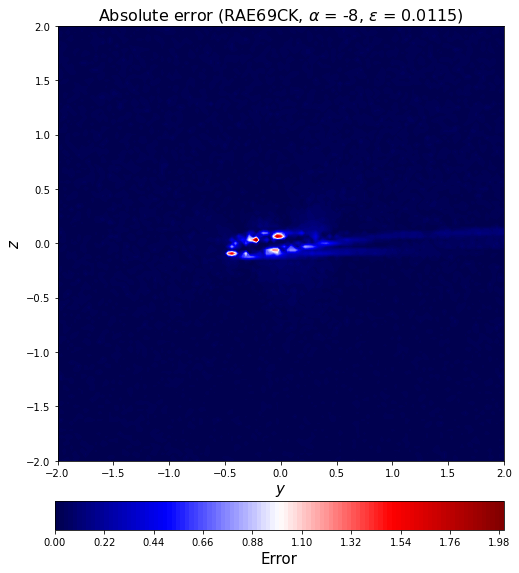

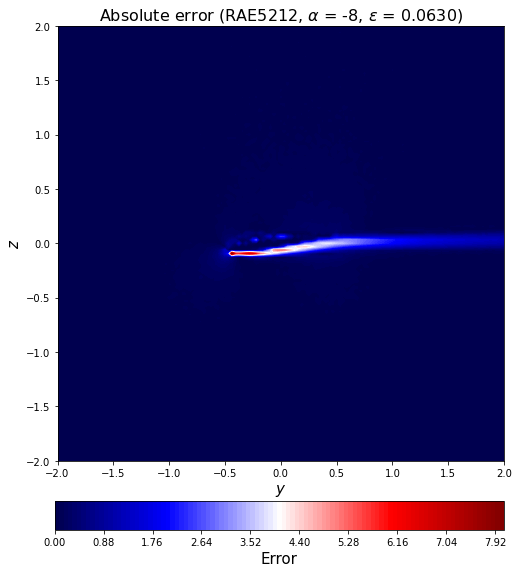

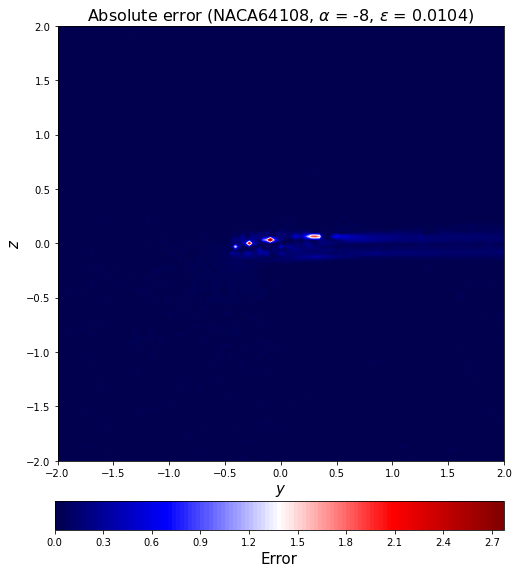

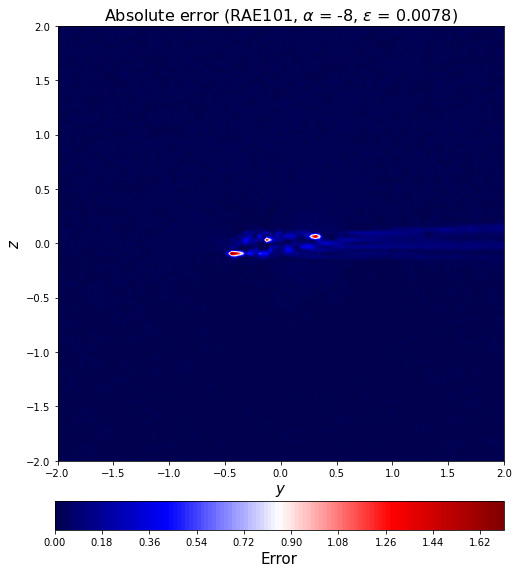

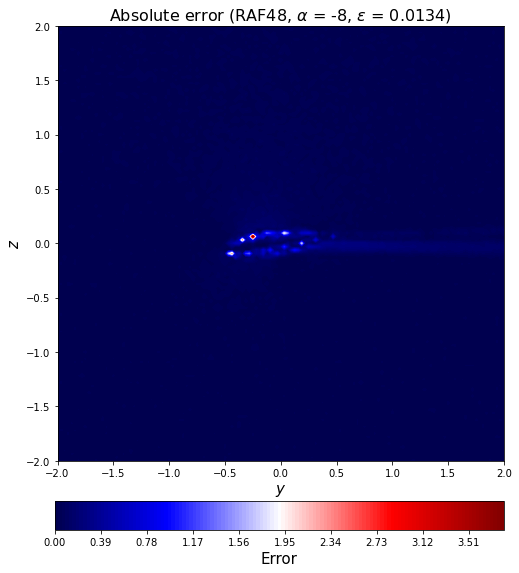

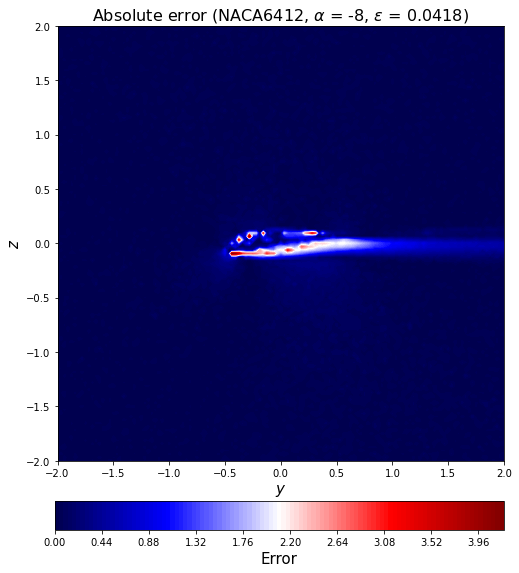

In [59]:
for c in range(0,14):
    error_test_abs2_rotate = error_test_abs[c].reshape(n_grid,n_grid)

    fig5 = plt.figure(figsize = (8, 8))
    ax5 = fig5.add_subplot(111)
    mappable = ax5.contourf(xmesh, ymesh, error_test_abs2_rotate, levels=128, cmap='seismic')
    ax5.set_title(r'Absolute error (%s, $\alpha$ = %d, $\epsilon$ = %.4f)' %(np.array2string(geo_test[c])[3:-2],
                                                                       aa_test[c], l2_error_test_list[c]), fontsize=16)
    ax5.set_xlabel('$y$', fontsize=15)
    ax5.set_ylabel('$z$', fontsize=15)

    cax = plt.axes([0.12, 0.005, 0.78, 0.05])
    cbar = plt.colorbar(mappable, cax=cax, orientation="horizontal")
    cbar.set_label('Error', fontsize=15)

    saveName = case_storage+ "\\testError"+str(np.array2string(geo_test[c])[3:-2])+"_alpha"+str(aa_test[c])+".jpg"
    plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

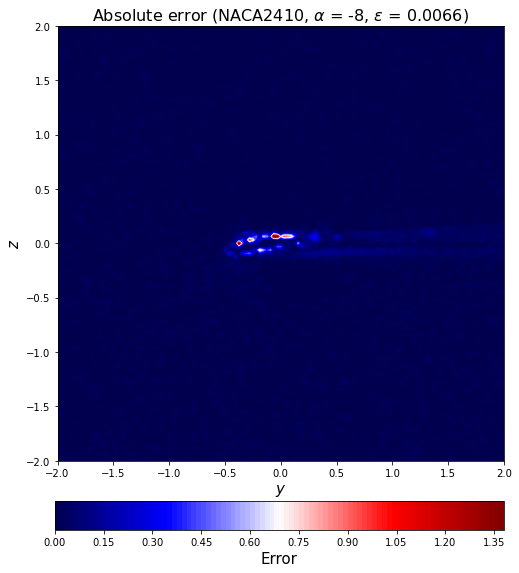

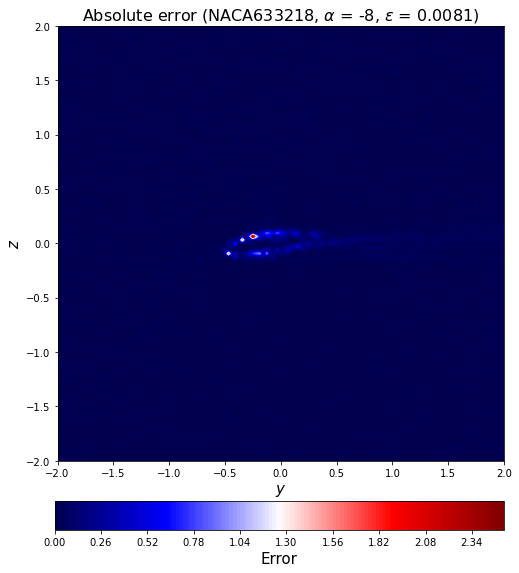

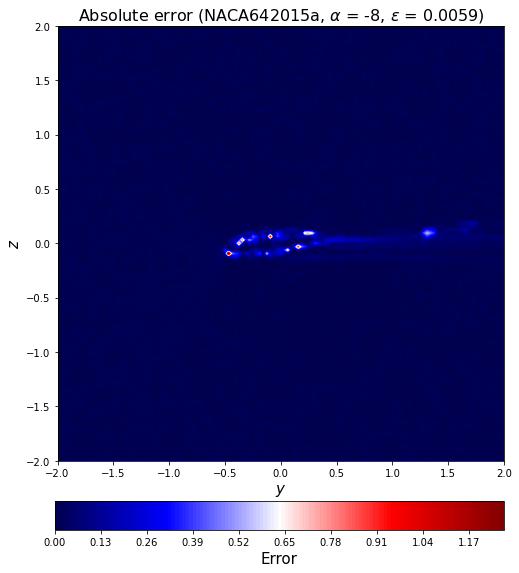

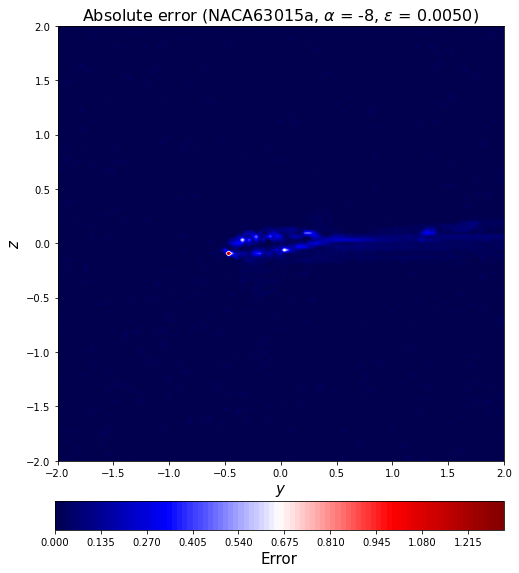

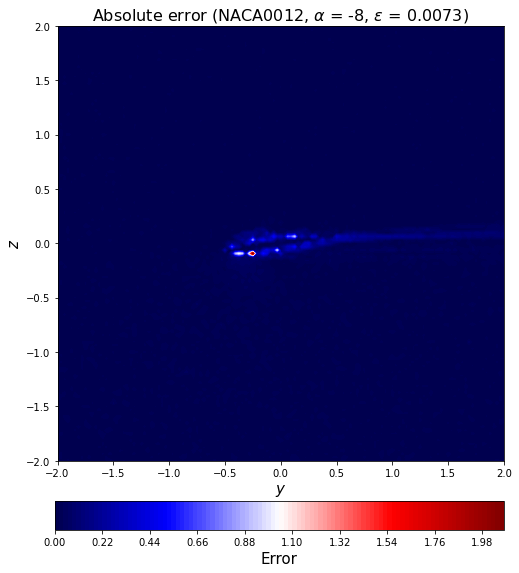

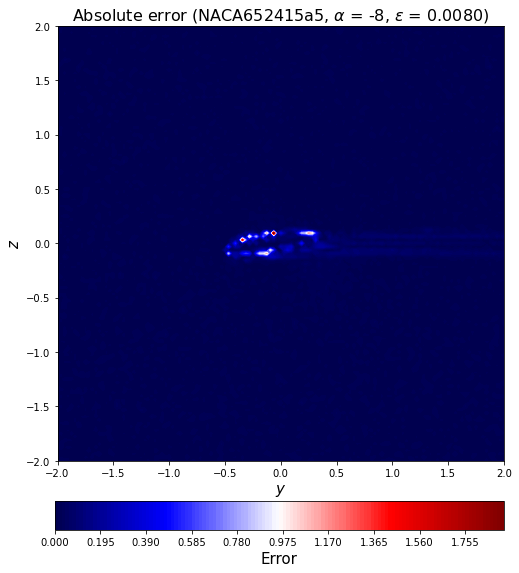

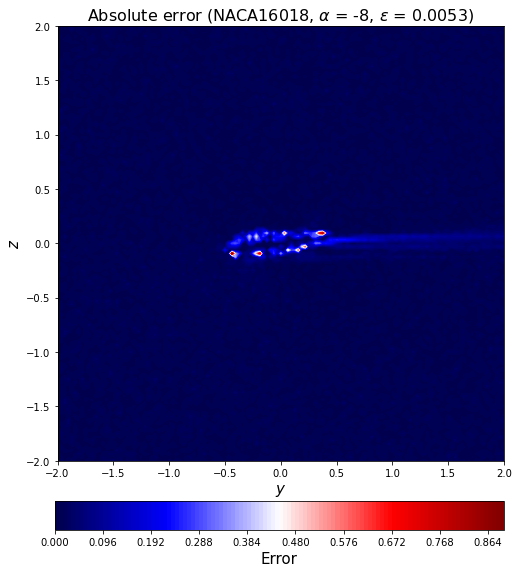

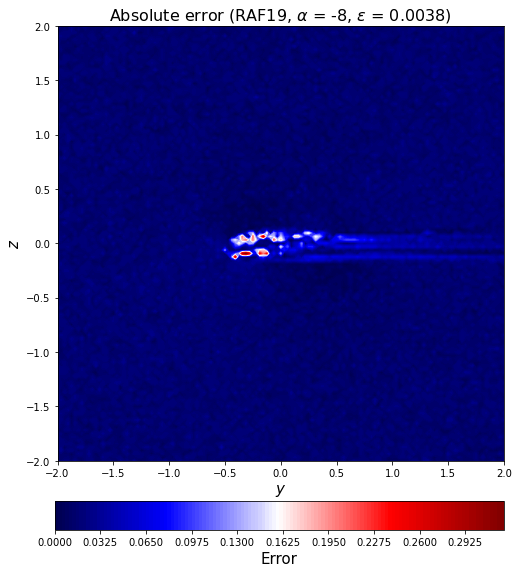

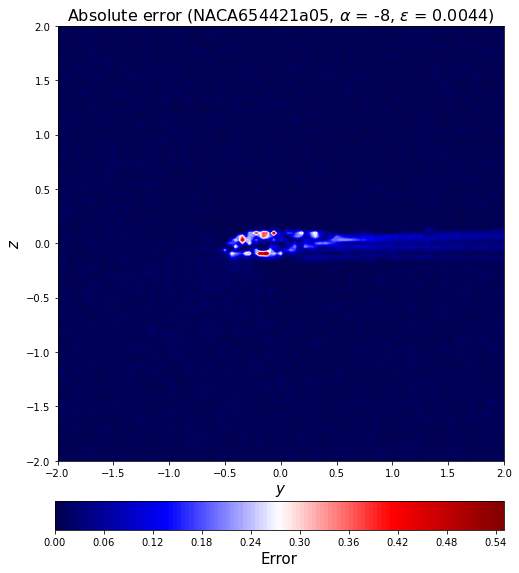

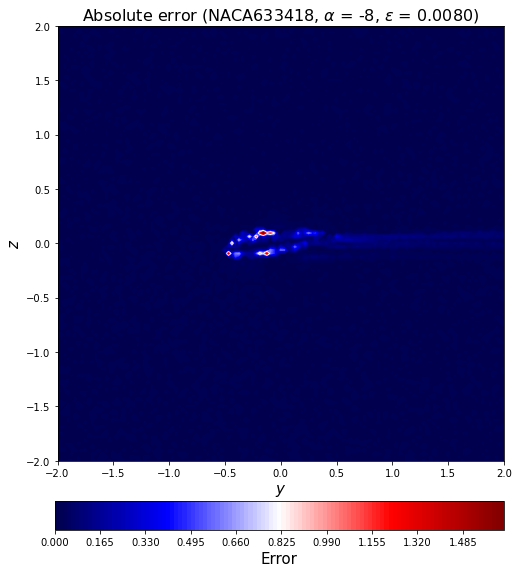

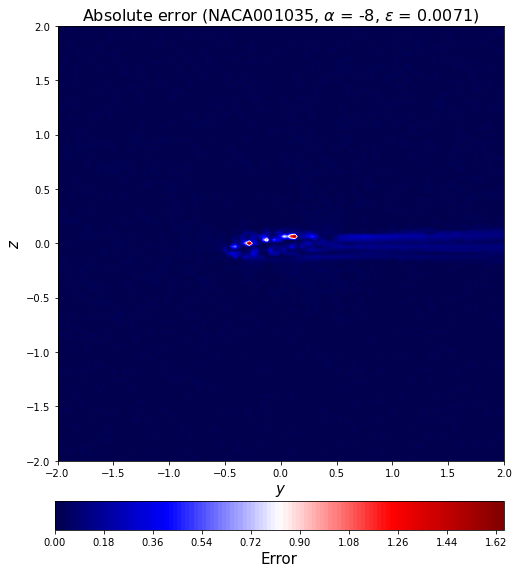

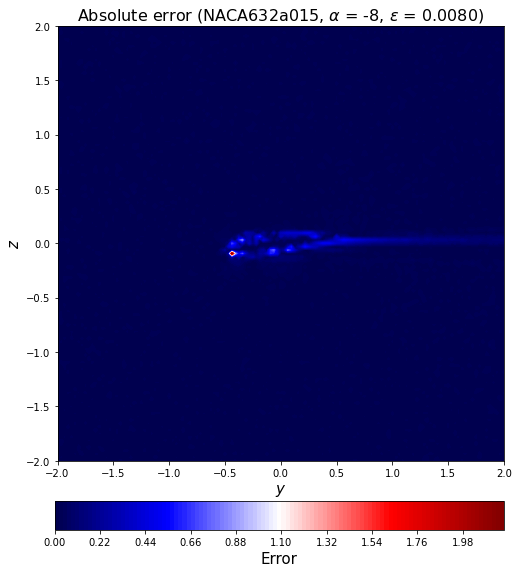

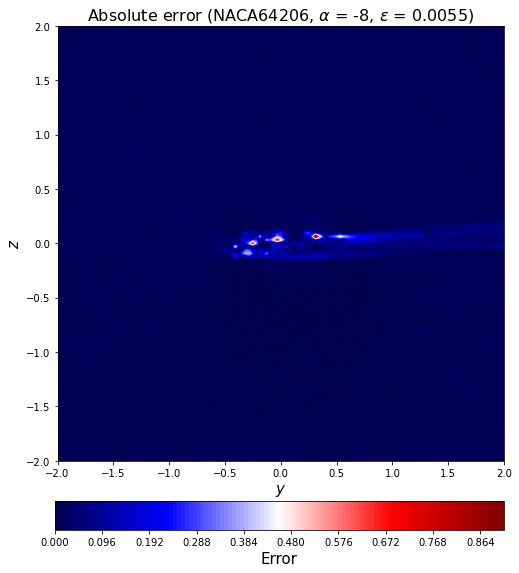

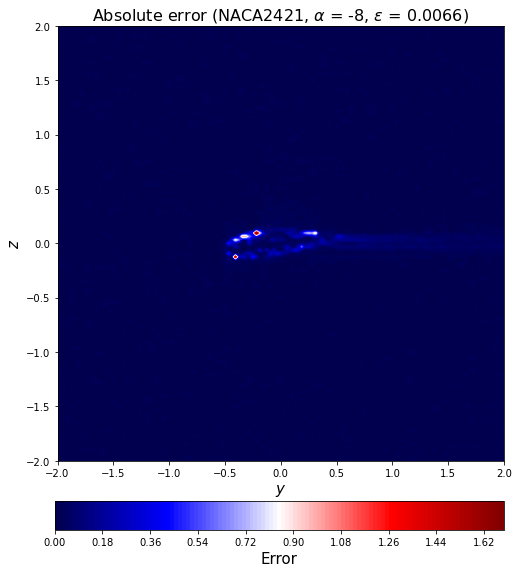

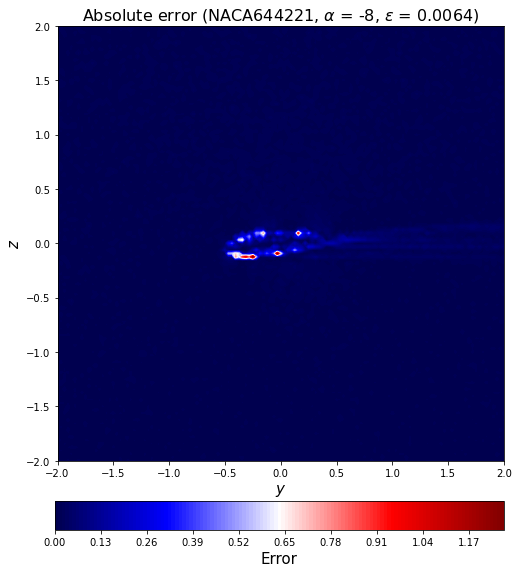

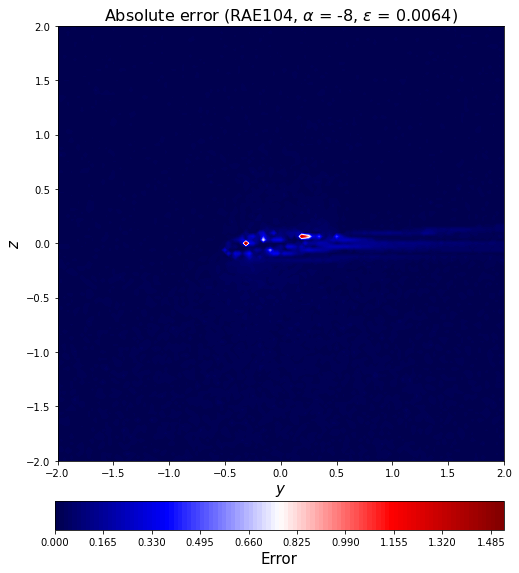

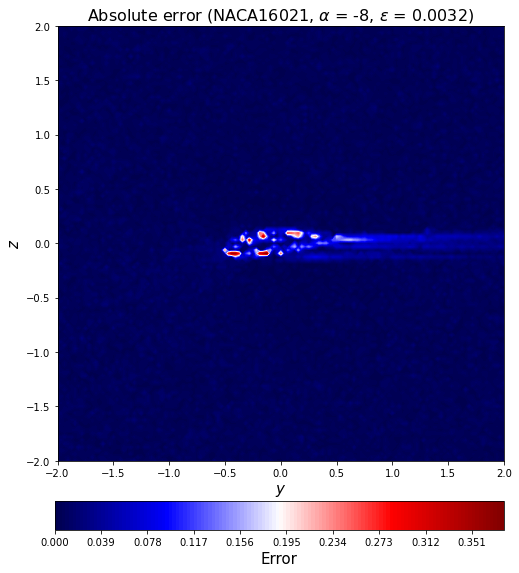

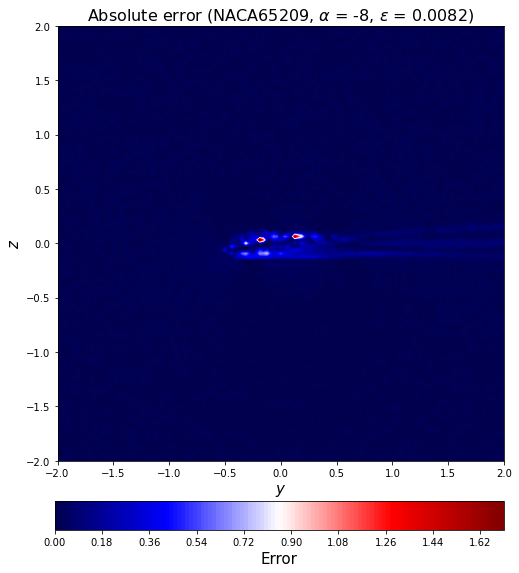

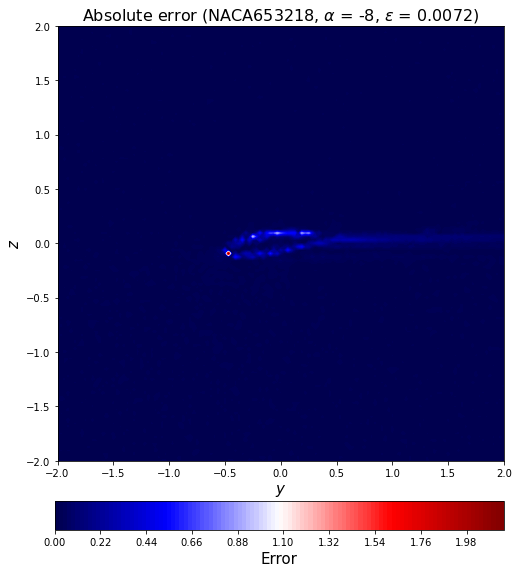

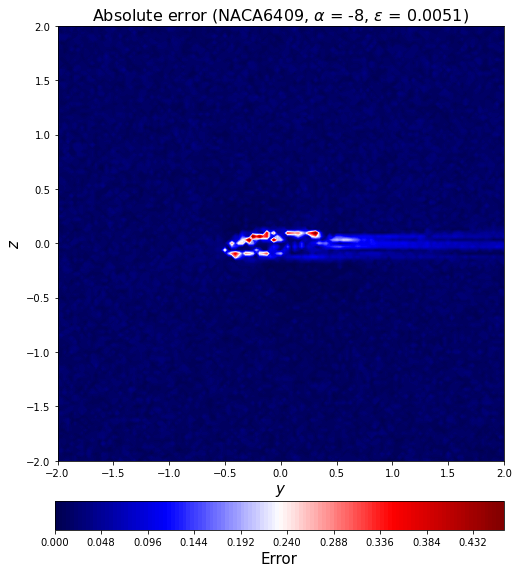

In [60]:
for c in range(0,20):
    error_train_abs2_rotate = error_train_abs[c].reshape(n_grid,n_grid)

    fig5 = plt.figure(figsize = (8, 8))
    ax5 = fig5.add_subplot(111)
    mappable = ax5.contourf(xmesh, ymesh, error_train_abs2_rotate, levels=128, cmap='seismic')
    ax5.set_title(r'Absolute error (%s, $\alpha$ = %d, $\epsilon$ = %.4f)' %(np.array2string(geo_train[c])[3:-2],
                                                                       aa_train[c], l2_error_train_list[c]), fontsize=16)
    ax5.set_xlabel('$y$', fontsize=15)
    ax5.set_ylabel('$z$', fontsize=15)

    cax = plt.axes([0.12, 0.005, 0.78, 0.05])
    cbar = plt.colorbar(mappable, cax=cax, orientation="horizontal")
    cbar.set_label('Error', fontsize=15)

    saveName = case_storage+ "\\trainingError"+str(np.array2string(geo_train[c])[3:-2])+"_alpha"+str(aa_train[c])+".jpg"
    plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()

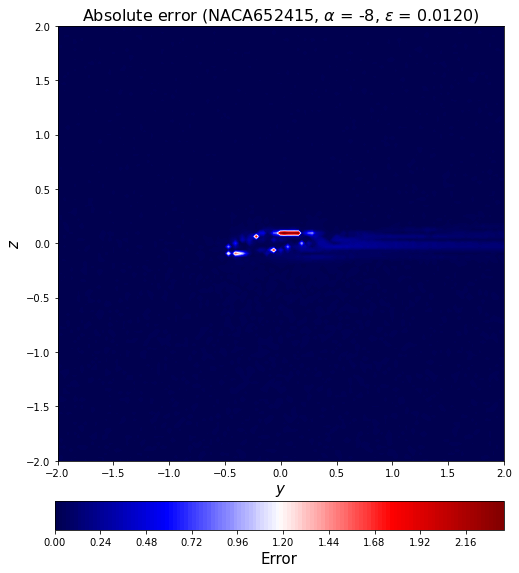

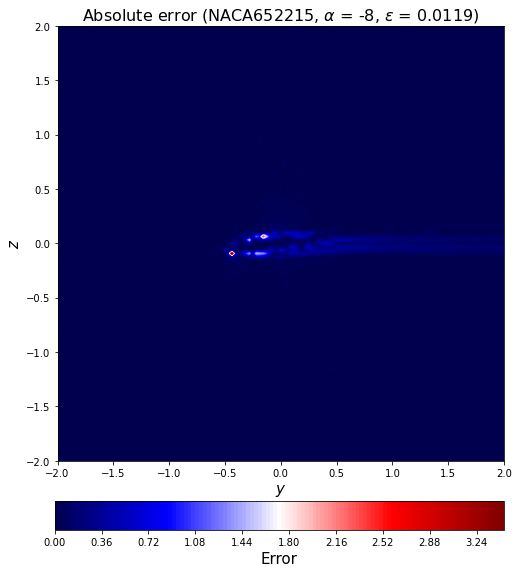

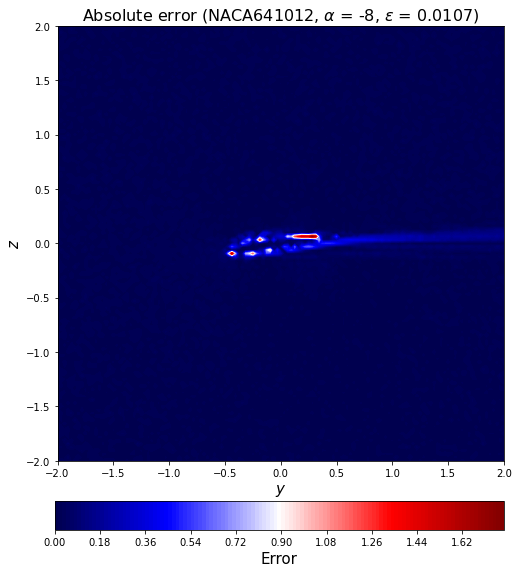

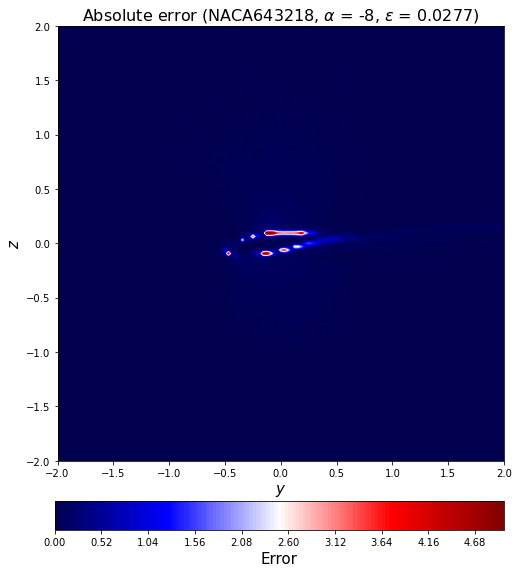

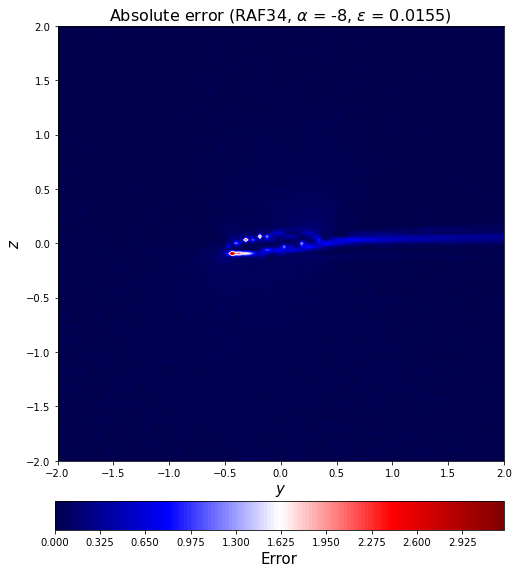

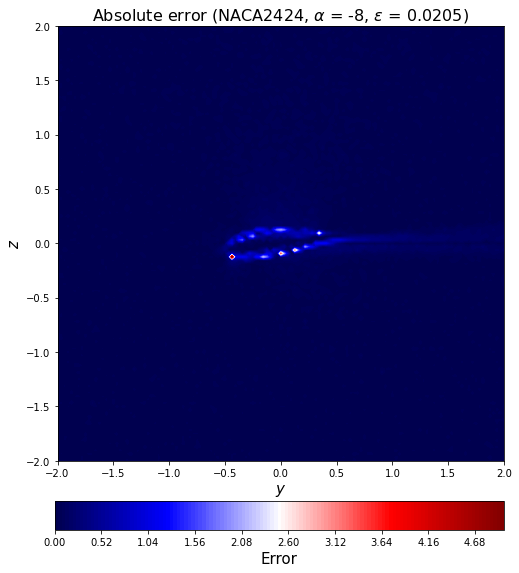

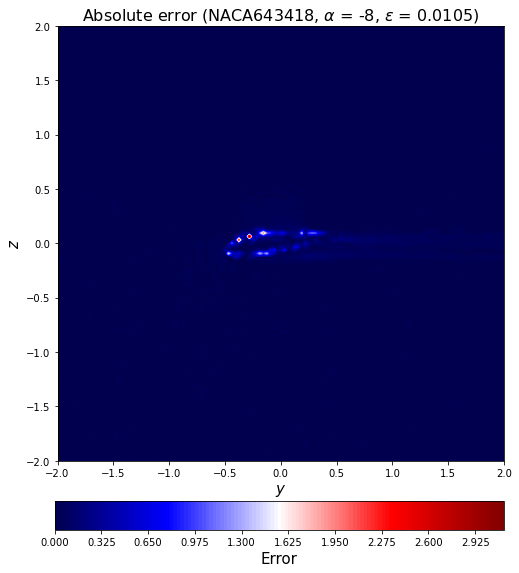

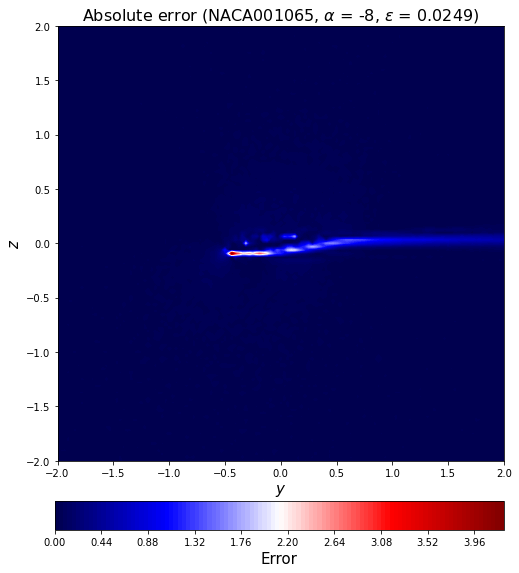

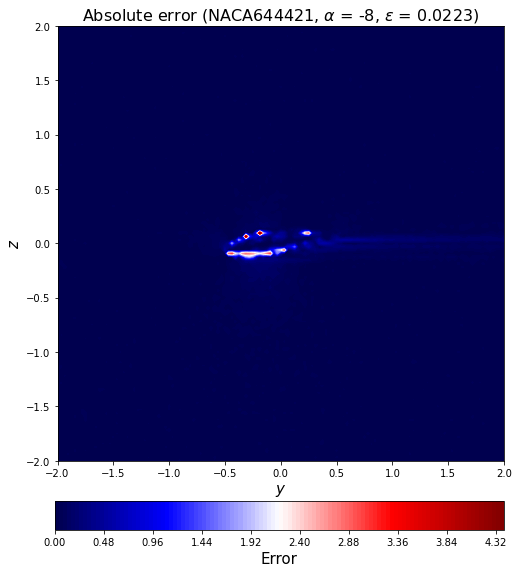

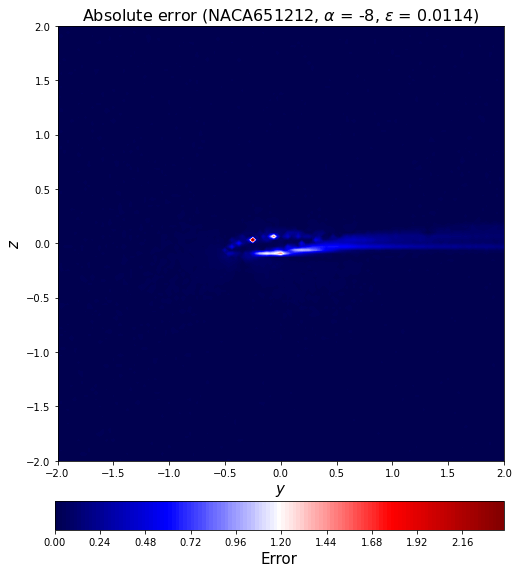

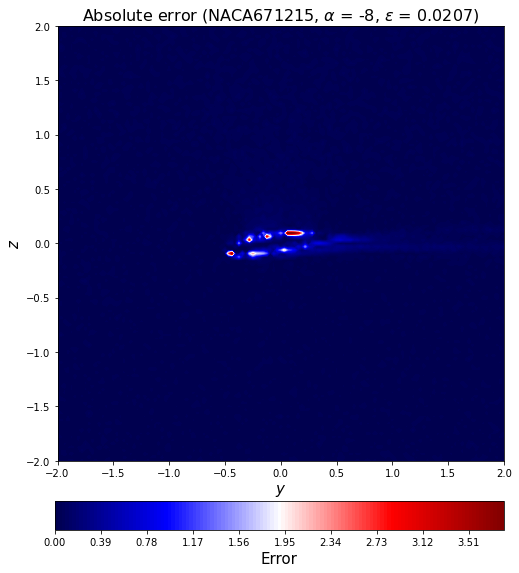

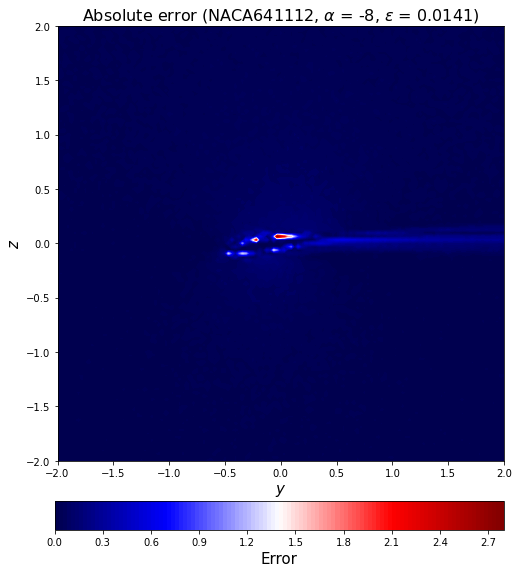

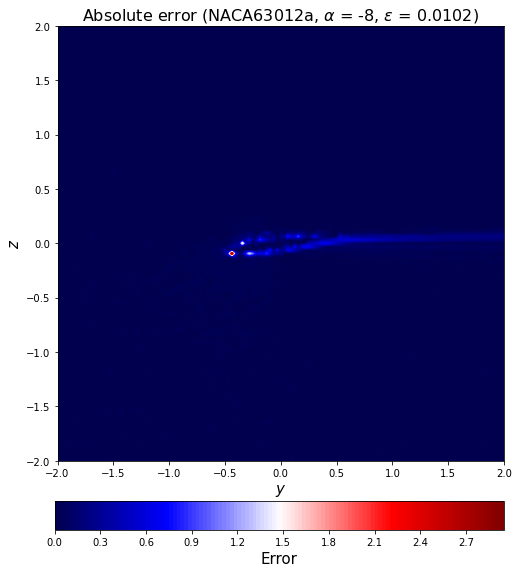

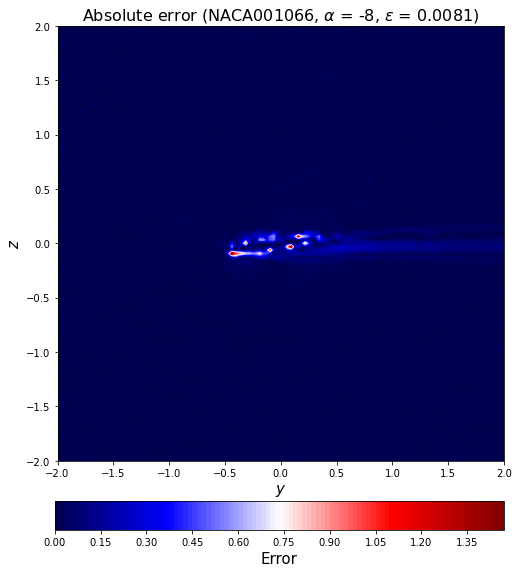

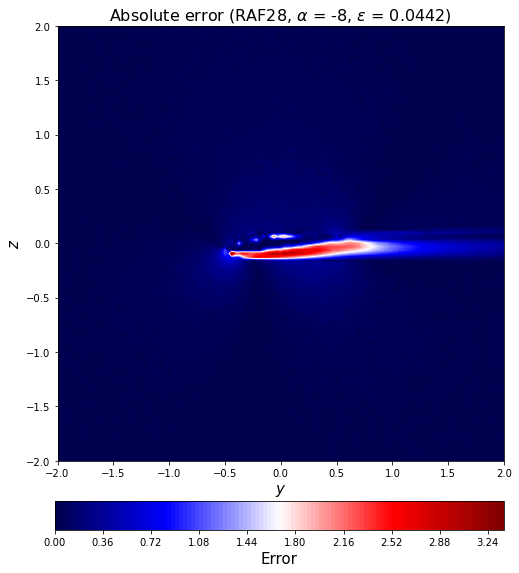

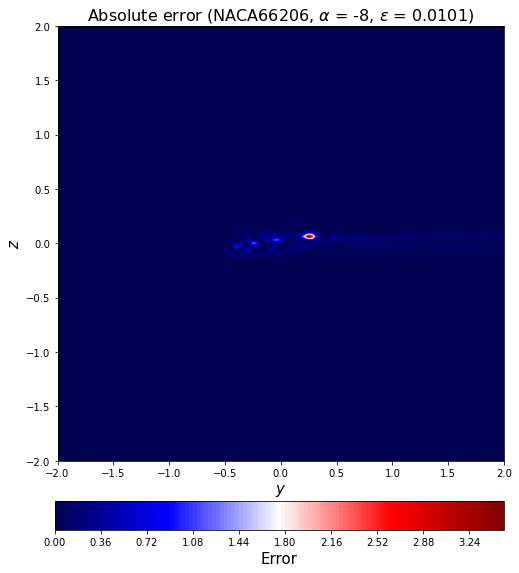

In [61]:
for c in range(0,16):
    error_val_abs2_rotate = error_val_abs[c].reshape(n_grid,n_grid)

    fig5 = plt.figure(figsize = (8, 8))
    ax5 = fig5.add_subplot(111)
    mappable = ax5.contourf(xmesh, ymesh, error_val_abs2_rotate, levels=128, cmap='seismic')
    ax5.set_title(r'Absolute error (%s, $\alpha$ = %d, $\epsilon$ = %.4f)' %(np.array2string(geo_val[c])[3:-2],
                                                                       aa_val[c], l2_error_val_list[c]), fontsize=16)
    ax5.set_xlabel('$y$', fontsize=15)
    ax5.set_ylabel('$z$', fontsize=15)

    cax = plt.axes([0.12, 0.005, 0.78, 0.05])
    cbar = plt.colorbar(mappable, cax=cax, orientation="horizontal")
    cbar.set_label('Error', fontsize=15)

    saveName = case_storage+ "\\validationError"+str(np.array2string(geo_val[c])[3:-2])+"_alpha"+str(aa_val[c])+".jpg"
    plt.savefig(saveName, dpi=300, bbox_inches='tight', pad_inches=0.3)
    plt.show()